In [ ]:
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer

#https://www.kaggle.com/code/enigmak/tabnet-deep-neural-network-for-tabular-data

#from base1 import *
from base2 import *

X_train_1 = pd.read_csv('csv/X_train_eu.csv', index_col='Unnamed: 0')
y_train = pd.read_csv('csv/y_train_eu.csv', index_col='Unnamed: 0')
X_val_1 = pd.read_csv('csv/X_val_eu.csv', index_col='Unnamed: 0')
y_val = pd.read_csv('csv/y_val_eu.csv', index_col='Unnamed: 0')
X_test_1 = pd.read_csv('csv/X_test_eu.csv', index_col='Unnamed: 0')
y_test = pd.read_csv('csv/y_test_eu.csv', index_col='Unnamed: 0')

y_train = (y_train['auop']).astype(str)
y_val = (y_val['auop']).astype(str)
y_test = (y_test['auop']).astype(str)

y_train = y_train.replace({'1': 1, '4': 0})
y_val = y_val.replace({'1': 1, '4': 0})
y_test = y_test.replace({'1': 1, '4': 0})

X_train = X_train_1
X_val = X_val_1
X_test = X_test_1

runned!
['PCA', 'SMOTE', 'SimpleImputer', 'StandardScaler', '__builtins__', '__cached__', '__doc__', '__file__', '__loader__', '__name__', '__package__', '__spec__', 'create_pca_table', 'np', 'pca_on_train_and_transform_full_data', 'pd', 'plt', 'preprocess_and_apply_smote1', 'remove_outliers_iqr', 'scale_columns1', 'scale_columns2']


<ipython-input-1-92ac18f58d88>:20: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  y_train = y_train.replace({'1': 1, '4': 0})
<ipython-input-1-92ac18f58d88>:21: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  y_val = y_val.replace({'1': 1, '4': 0})
<ipython-input-1-92ac18f58d88>:22: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_

In [ ]:
# Calculate frequency encoding on the training set
frequency_encoding = X_train['X140'].value_counts(normalize=True)
# Map the frequencies to the sector column in each dataset
X_train['X141'] = X_train['X140'].map(frequency_encoding)
X_val['X141'] = X_val['X140'].map(frequency_encoding)
X_test['X141'] = X_test['X140'].map(frequency_encoding)
# Fill any missing values that might arise if a category in val/test wasn't in train
X_val['X141'].fillna(0, inplace=True)
X_test['X141'].fillna(0, inplace=True)

X_train = X_train.drop(columns=['X140'])
X_val = X_val.drop(columns=['X140'])
X_test = X_test.drop(columns=['X140'])

# Deal with missing values in the features 
missing_threshold = 0.8
missing_train = X_train.isnull().mean()
cols_to_drop = missing_train[missing_train > missing_threshold].index
# Drop the identified columns from both the training and test sets
X_train = X_train.drop(cols_to_drop, axis=1)
X_val = X_val.drop(cols_to_drop, axis=1)
X_test = X_test.drop(cols_to_drop, axis=1)
print(f"Columns dropped: {list(cols_to_drop)}")
print(len(cols_to_drop))

col_names = X_train.columns.to_list()
col_names.remove("X23")
col_names.remove("X141")

Columns dropped: ['X20', 'X119']
2


<ipython-input-2-f194cd05e0f5>:8: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  X_val['X141'].fillna(0, inplace=True)
<ipython-input-2-f194cd05e0f5>:9: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method(

In [ ]:
# Replace 'inf' and '-inf' with NaN
X_train.replace([np.inf, -np.inf], np.nan, inplace=True)
X_val.replace([np.inf, -np.inf], np.nan, inplace=True)
X_test.replace([np.inf, -np.inf], np.nan, inplace=True)

# Initialize SimpleImputer with the 'mean' strategy
imputer = SimpleImputer(strategy='mean')
# Fit the imputer on the training data and transform it
X_train = pd.DataFrame(imputer.fit_transform(X_train), columns=X_train.columns)
# Apply the same imputer to the validation and test sets (without refitting)
X_val = pd.DataFrame(imputer.transform(X_val), columns=X_train.columns)
X_test = pd.DataFrame(imputer.transform(X_test), columns=X_train.columns)

In [ ]:
from pytorch_tabnet.tab_model import TabNetClassifier
import torch
from sklearn.metrics import roc_auc_score, balanced_accuracy_score, f1_score, precision_recall_curve, auc

# Convert DataFrames to NumPy arrays
X_train_np = X_train.values
X_val_np = X_val.values
X_test_np = X_test.values

In [ ]:
import torch
import optuna
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_selection import chi2
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import average_precision_score
from pytorch_tabnet.tab_model import TabNetClassifier
from pytorch_tabnet.metrics import Metric
from sklearn.model_selection import train_test_split

In [ ]:
def objective(trial):

    hyperparams = {
        'n_a_d': trial.suggest_categorical('n_a_d', [8, 16, 24, 32, 64, 128, 256]),
        'n_steps': trial.suggest_int('n_steps', 3, 10, 1),
        'gamma': trial.suggest_categorical('gamma', [0.01, 0.05, 0.1, 0.5, 0.8, 1.0, 1.2, 1.5, 2.0]),
        'lambda': trial.suggest_categorical('lambda', [0.1, 0.01, 0.001, 0.0001, 0.00001, 0.000001, 0.0000001, 0]),
        'batch_size': trial.suggest_categorical('batch_size', [1024, 2048, 4096, 8192, 16384, 32768]),
        'virtual_batch_size': trial.suggest_categorical('virtual_batch_size', [128, 256, 512, 1024, 2028, 4096]),
        'lr': trial.suggest_categorical('lr', [0.005, 0.01, 0.02, 0.025, 0.03, 0.04, 0.05]),
        'gamma_decay': trial.suggest_categorical('gamma_decay', [0.4, 0.8, 0.9, 0.95]),
        'mask_type': trial.suggest_categorical('mask_type', ['entmax', 'sparsemax']),
        'batch_momentum': trial.suggest_categorical('batch_momentum', [0.6, 0.7, 0.8, 0.9, 0.95, 0.98]),
    }
    MAX_EPOCHS = 35
    PATIENCE = 5
    model = TabNetClassifier(
        n_d=hyperparams['n_a_d'],
        n_a=hyperparams['n_a_d'],
        gamma=hyperparams['gamma'],
        optimizer_fn=torch.optim.Adam,
        optimizer_params={'lr':hyperparams['lr']},
        scheduler_params={"step_size":hyperparams['n_steps'],
                          "gamma":hyperparams['gamma_decay']},
        scheduler_fn=torch.optim.lr_scheduler.StepLR,
        mask_type=hyperparams['mask_type'],
        lambda_sparse=hyperparams['lambda'],
        momentum=hyperparams['batch_momentum'],
        verbose = 0
    )
    model.fit(
        X_train=X_train_np, y_train=y_train,
        eval_set=[(X_train_np, y_train), (X_val_np, y_val)],
        eval_name=['train', 'val'],
        max_epochs=MAX_EPOCHS, 
        patience=PATIENCE,
        batch_size=hyperparams['batch_size'],
        virtual_batch_size=hyperparams['virtual_batch_size'],
        num_workers=0,
        drop_last=False
    )

    val_preds = model.predict(X_val_np)
    
    del model

    return average_precision_score(y_val,val_preds)

In [ ]:
study = optuna.create_study(direction='maximize',
                            sampler=optuna.samplers.TPESampler(multivariate=True, seed=42))

/opt/anaconda3/lib/python3.11/site-packages/optuna/_experimental.py:30: ExperimentalWarning: Argument ``multivariate`` is an experimental feature. The interface can change in the future.
  warnings.warn(
[I 2024-11-18 10:23:08,979] A new study created in memory with name: no-name-0ff3b853-87a1-4ac9-93ca-bb569da8eb3a


In [ ]:
study.optimize(objective, 
               timeout=60*60*6, 
               n_trials=250, 
               gc_after_trial=False)

<ipython-input-6-28ed69af07b4>:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_steps': trial.suggest_int('n_steps', 3, 10, 1),



Early stopping occurred at epoch 16 with best_epoch = 11 and best_val_auc = 0.72921


/opt/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-11-18 10:23:26,670] Trial 0 finished with value: 0.7669368913646283 and parameters: {'n_a_d': 16, 'n_steps': 9, 'gamma': 0.5, 'lambda': 0.0001, 'batch_size': 1024, 'virtual_batch_size': 1024, 'lr': 0.05, 'gamma_decay': 0.8, 'mask_type': 'entmax', 'batch_momentum': 0.6}. Best is trial 0 with value: 0.7669368913646283.
<ipython-input-6-28ed69af07b4>:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_steps': trial.suggest_int('n_steps', 3, 10, 1),



Early stopping occurred at epoch 9 with best_epoch = 4 and best_val_auc = 0.57302


/opt/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-11-18 10:24:15,044] Trial 1 finished with value: 0.7649807197313618 and parameters: {'n_a_d': 256, 'n_steps': 5, 'gamma': 1.0, 'lambda': 0, 'batch_size': 32768, 'virtual_batch_size': 256, 'lr': 0.01, 'gamma_decay': 0.8, 'mask_type': 'entmax', 'batch_momentum': 0.7}. Best is trial 0 with value: 0.7669368913646283.
<ipython-input-6-28ed69af07b4>:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_steps': trial.suggest_int('n_steps', 3, 10, 1),


Stop training because you reached max_epochs = 35 with best_epoch = 30 and best_val_auc = 0.70392


/opt/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-11-18 10:24:31,704] Trial 2 finished with value: 0.7729262034716449 and parameters: {'n_a_d': 8, 'n_steps': 7, 'gamma': 0.05, 'lambda': 1e-06, 'batch_size': 4096, 'virtual_batch_size': 1024, 'lr': 0.04, 'gamma_decay': 0.8, 'mask_type': 'sparsemax', 'batch_momentum': 0.9}. Best is trial 2 with value: 0.7729262034716449.
<ipython-input-6-28ed69af07b4>:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_steps': trial.suggest_int('n_steps', 3, 10, 1),



Early stopping occurred at epoch 19 with best_epoch = 14 and best_val_auc = 0.62351


/opt/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-11-18 10:24:45,516] Trial 3 finished with value: 0.7626172149286112 and parameters: {'n_a_d': 24, 'n_steps': 4, 'gamma': 0.1, 'lambda': 0, 'batch_size': 16384, 'virtual_batch_size': 2028, 'lr': 0.05, 'gamma_decay': 0.9, 'mask_type': 'sparsemax', 'batch_momentum': 0.7}. Best is trial 2 with value: 0.7729262034716449.
<ipython-input-6-28ed69af07b4>:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_steps': trial.suggest_int('n_steps', 3, 10, 1),



Early stopping occurred at epoch 22 with best_epoch = 17 and best_val_auc = 0.62743


/opt/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-11-18 10:25:07,309] Trial 4 finished with value: 0.7611354335654696 and parameters: {'n_a_d': 24, 'n_steps': 7, 'gamma': 2.0, 'lambda': 1e-07, 'batch_size': 1024, 'virtual_batch_size': 256, 'lr': 0.005, 'gamma_decay': 0.95, 'mask_type': 'sparsemax', 'batch_momentum': 0.8}. Best is trial 2 with value: 0.7729262034716449.
<ipython-input-6-28ed69af07b4>:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_steps': trial.suggest_int('n_steps', 3, 10, 1),



Early stopping occurred at epoch 26 with best_epoch = 21 and best_val_auc = 0.72958


/opt/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-11-18 10:25:24,366] Trial 5 finished with value: 0.769199098519293 and parameters: {'n_a_d': 8, 'n_steps': 7, 'gamma': 0.8, 'lambda': 0, 'batch_size': 1024, 'virtual_batch_size': 512, 'lr': 0.03, 'gamma_decay': 0.4, 'mask_type': 'entmax', 'batch_momentum': 0.7}. Best is trial 2 with value: 0.7729262034716449.
<ipython-input-6-28ed69af07b4>:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_steps': trial.suggest_int('n_steps', 3, 10, 1),



Early stopping occurred at epoch 8 with best_epoch = 3 and best_val_auc = 0.55244


/opt/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-11-18 10:25:30,077] Trial 6 finished with value: 0.7652848624885162 and parameters: {'n_a_d': 8, 'n_steps': 6, 'gamma': 1.5, 'lambda': 1e-06, 'batch_size': 32768, 'virtual_batch_size': 128, 'lr': 0.025, 'gamma_decay': 0.95, 'mask_type': 'sparsemax', 'batch_momentum': 0.95}. Best is trial 2 with value: 0.7729262034716449.
<ipython-input-6-28ed69af07b4>:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_steps': trial.suggest_int('n_steps', 3, 10, 1),



Early stopping occurred at epoch 16 with best_epoch = 11 and best_val_auc = 0.58265


/opt/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-11-18 10:25:42,282] Trial 7 finished with value: 0.7638376837912363 and parameters: {'n_a_d': 32, 'n_steps': 9, 'gamma': 2.0, 'lambda': 0.0001, 'batch_size': 8192, 'virtual_batch_size': 2028, 'lr': 0.02, 'gamma_decay': 0.8, 'mask_type': 'sparsemax', 'batch_momentum': 0.95}. Best is trial 2 with value: 0.7729262034716449.
<ipython-input-6-28ed69af07b4>:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_steps': trial.suggest_int('n_steps', 3, 10, 1),


Stop training because you reached max_epochs = 35 with best_epoch = 30 and best_val_auc = 0.72147


/opt/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-11-18 10:26:39,944] Trial 8 finished with value: 0.7672172050946546 and parameters: {'n_a_d': 128, 'n_steps': 6, 'gamma': 2.0, 'lambda': 1e-07, 'batch_size': 4096, 'virtual_batch_size': 512, 'lr': 0.025, 'gamma_decay': 0.9, 'mask_type': 'entmax', 'batch_momentum': 0.7}. Best is trial 2 with value: 0.7729262034716449.
<ipython-input-6-28ed69af07b4>:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_steps': trial.suggest_int('n_steps', 3, 10, 1),



Early stopping occurred at epoch 16 with best_epoch = 11 and best_val_auc = 0.64001


/opt/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-11-18 10:26:55,946] Trial 9 finished with value: 0.7641425239872479 and parameters: {'n_a_d': 64, 'n_steps': 6, 'gamma': 1.2, 'lambda': 0.01, 'batch_size': 4096, 'virtual_batch_size': 4096, 'lr': 0.02, 'gamma_decay': 0.95, 'mask_type': 'sparsemax', 'batch_momentum': 0.6}. Best is trial 2 with value: 0.7729262034716449.
<ipython-input-6-28ed69af07b4>:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_steps': trial.suggest_int('n_steps', 3, 10, 1),



Early stopping occurred at epoch 27 with best_epoch = 22 and best_val_auc = 0.70354


/opt/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-11-18 10:27:42,490] Trial 10 finished with value: 0.7701778130669558 and parameters: {'n_a_d': 128, 'n_steps': 4, 'gamma': 0.05, 'lambda': 1e-07, 'batch_size': 4096, 'virtual_batch_size': 1024, 'lr': 0.05, 'gamma_decay': 0.8, 'mask_type': 'sparsemax', 'batch_momentum': 0.9}. Best is trial 2 with value: 0.7729262034716449.
<ipython-input-6-28ed69af07b4>:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_steps': trial.suggest_int('n_steps', 3, 10, 1),



Early stopping occurred at epoch 24 with best_epoch = 19 and best_val_auc = 0.74331


/opt/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-11-18 10:28:02,343] Trial 11 finished with value: 0.7747381277427644 and parameters: {'n_a_d': 32, 'n_steps': 9, 'gamma': 0.1, 'lambda': 1e-06, 'batch_size': 2048, 'virtual_batch_size': 1024, 'lr': 0.04, 'gamma_decay': 0.8, 'mask_type': 'sparsemax', 'batch_momentum': 0.9}. Best is trial 11 with value: 0.7747381277427644.
<ipython-input-6-28ed69af07b4>:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_steps': trial.suggest_int('n_steps', 3, 10, 1),



Early stopping occurred at epoch 24 with best_epoch = 19 and best_val_auc = 0.74378


/opt/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-11-18 10:28:22,042] Trial 12 finished with value: 0.7800486634596242 and parameters: {'n_a_d': 32, 'n_steps': 9, 'gamma': 0.01, 'lambda': 0, 'batch_size': 2048, 'virtual_batch_size': 1024, 'lr': 0.04, 'gamma_decay': 0.8, 'mask_type': 'sparsemax', 'batch_momentum': 0.9}. Best is trial 12 with value: 0.7800486634596242.
<ipython-input-6-28ed69af07b4>:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_steps': trial.suggest_int('n_steps', 3, 10, 1),



Early stopping occurred at epoch 26 with best_epoch = 21 and best_val_auc = 0.76299


/opt/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-11-18 10:29:06,046] Trial 13 finished with value: 0.7814819980725985 and parameters: {'n_a_d': 128, 'n_steps': 9, 'gamma': 0.01, 'lambda': 0.001, 'batch_size': 2048, 'virtual_batch_size': 1024, 'lr': 0.04, 'gamma_decay': 0.8, 'mask_type': 'entmax', 'batch_momentum': 0.9}. Best is trial 13 with value: 0.7814819980725985.
<ipython-input-6-28ed69af07b4>:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_steps': trial.suggest_int('n_steps', 3, 10, 1),



Early stopping occurred at epoch 29 with best_epoch = 24 and best_val_auc = 0.7137


/opt/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-11-18 10:29:58,617] Trial 14 finished with value: 0.7662882129186822 and parameters: {'n_a_d': 128, 'n_steps': 5, 'gamma': 0.01, 'lambda': 0.01, 'batch_size': 2048, 'virtual_batch_size': 128, 'lr': 0.005, 'gamma_decay': 0.8, 'mask_type': 'entmax', 'batch_momentum': 0.6}. Best is trial 13 with value: 0.7814819980725985.
<ipython-input-6-28ed69af07b4>:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_steps': trial.suggest_int('n_steps', 3, 10, 1),



Early stopping occurred at epoch 27 with best_epoch = 22 and best_val_auc = 0.74387


/opt/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-11-18 10:30:14,278] Trial 15 finished with value: 0.776500963522815 and parameters: {'n_a_d': 8, 'n_steps': 10, 'gamma': 0.01, 'lambda': 0, 'batch_size': 2048, 'virtual_batch_size': 1024, 'lr': 0.04, 'gamma_decay': 0.95, 'mask_type': 'entmax', 'batch_momentum': 0.9}. Best is trial 13 with value: 0.7814819980725985.
<ipython-input-6-28ed69af07b4>:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_steps': trial.suggest_int('n_steps', 3, 10, 1),



Early stopping occurred at epoch 28 with best_epoch = 23 and best_val_auc = 0.68447


/opt/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-11-18 10:31:02,813] Trial 16 finished with value: 0.7664867785523879 and parameters: {'n_a_d': 128, 'n_steps': 9, 'gamma': 2.0, 'lambda': 0, 'batch_size': 4096, 'virtual_batch_size': 1024, 'lr': 0.03, 'gamma_decay': 0.8, 'mask_type': 'entmax', 'batch_momentum': 0.9}. Best is trial 13 with value: 0.7814819980725985.
<ipython-input-6-28ed69af07b4>:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_steps': trial.suggest_int('n_steps', 3, 10, 1),



Early stopping occurred at epoch 12 with best_epoch = 7 and best_val_auc = 0.59263


/opt/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-11-18 10:31:32,540] Trial 17 finished with value: 0.7668803466867936 and parameters: {'n_a_d': 128, 'n_steps': 9, 'gamma': 1.2, 'lambda': 0.001, 'batch_size': 16384, 'virtual_batch_size': 1024, 'lr': 0.04, 'gamma_decay': 0.9, 'mask_type': 'entmax', 'batch_momentum': 0.8}. Best is trial 13 with value: 0.7814819980725985.
<ipython-input-6-28ed69af07b4>:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_steps': trial.suggest_int('n_steps', 3, 10, 1),



Early stopping occurred at epoch 23 with best_epoch = 18 and best_val_auc = 0.74238


/opt/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-11-18 10:31:49,725] Trial 18 finished with value: 0.7938735833360016 and parameters: {'n_a_d': 32, 'n_steps': 8, 'gamma': 0.01, 'lambda': 0, 'batch_size': 2048, 'virtual_batch_size': 2028, 'lr': 0.04, 'gamma_decay': 0.8, 'mask_type': 'sparsemax', 'batch_momentum': 0.8}. Best is trial 18 with value: 0.7938735833360016.
<ipython-input-6-28ed69af07b4>:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_steps': trial.suggest_int('n_steps', 3, 10, 1),


Stop training because you reached max_epochs = 35 with best_epoch = 34 and best_val_auc = 0.75934


/opt/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-11-18 10:32:47,977] Trial 19 finished with value: 0.7720868881244292 and parameters: {'n_a_d': 128, 'n_steps': 5, 'gamma': 2.0, 'lambda': 0, 'batch_size': 2048, 'virtual_batch_size': 2028, 'lr': 0.04, 'gamma_decay': 0.8, 'mask_type': 'sparsemax', 'batch_momentum': 0.8}. Best is trial 18 with value: 0.7938735833360016.
<ipython-input-6-28ed69af07b4>:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_steps': trial.suggest_int('n_steps', 3, 10, 1),


Stop training because you reached max_epochs = 35 with best_epoch = 31 and best_val_auc = 0.70588


/opt/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-11-18 10:33:14,204] Trial 20 finished with value: 0.7714890818816345 and parameters: {'n_a_d': 32, 'n_steps': 7, 'gamma': 0.05, 'lambda': 0, 'batch_size': 2048, 'virtual_batch_size': 2028, 'lr': 0.005, 'gamma_decay': 0.9, 'mask_type': 'sparsemax', 'batch_momentum': 0.8}. Best is trial 18 with value: 0.7938735833360016.
<ipython-input-6-28ed69af07b4>:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_steps': trial.suggest_int('n_steps', 3, 10, 1),



Early stopping occurred at epoch 27 with best_epoch = 22 and best_val_auc = 0.7167


/opt/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-11-18 10:33:33,667] Trial 21 finished with value: 0.7648578083978023 and parameters: {'n_a_d': 24, 'n_steps': 9, 'gamma': 1.2, 'lambda': 0.001, 'batch_size': 2048, 'virtual_batch_size': 512, 'lr': 0.04, 'gamma_decay': 0.8, 'mask_type': 'entmax', 'batch_momentum': 0.9}. Best is trial 18 with value: 0.7938735833360016.
<ipython-input-6-28ed69af07b4>:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_steps': trial.suggest_int('n_steps', 3, 10, 1),



Early stopping occurred at epoch 34 with best_epoch = 29 and best_val_auc = 0.76756


/opt/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-11-18 10:34:28,988] Trial 22 finished with value: 0.7879053720999016 and parameters: {'n_a_d': 128, 'n_steps': 8, 'gamma': 0.01, 'lambda': 0.001, 'batch_size': 2048, 'virtual_batch_size': 1024, 'lr': 0.04, 'gamma_decay': 0.8, 'mask_type': 'entmax', 'batch_momentum': 0.95}. Best is trial 18 with value: 0.7938735833360016.
<ipython-input-6-28ed69af07b4>:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_steps': trial.suggest_int('n_steps', 3, 10, 1),



Early stopping occurred at epoch 5 with best_epoch = 0 and best_val_auc = 0.56732


/opt/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-11-18 10:34:40,240] Trial 23 finished with value: 0.7619716103028 and parameters: {'n_a_d': 128, 'n_steps': 6, 'gamma': 0.01, 'lambda': 0.001, 'batch_size': 8192, 'virtual_batch_size': 1024, 'lr': 0.04, 'gamma_decay': 0.8, 'mask_type': 'entmax', 'batch_momentum': 0.95}. Best is trial 18 with value: 0.7938735833360016.
<ipython-input-6-28ed69af07b4>:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_steps': trial.suggest_int('n_steps', 3, 10, 1),


Stop training because you reached max_epochs = 35 with best_epoch = 30 and best_val_auc = 0.74495


/opt/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-11-18 10:35:33,902] Trial 24 finished with value: 0.7947849889761689 and parameters: {'n_a_d': 128, 'n_steps': 9, 'gamma': 0.01, 'lambda': 0.001, 'batch_size': 2048, 'virtual_batch_size': 1024, 'lr': 0.01, 'gamma_decay': 0.8, 'mask_type': 'entmax', 'batch_momentum': 0.9}. Best is trial 24 with value: 0.7947849889761689.
<ipython-input-6-28ed69af07b4>:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_steps': trial.suggest_int('n_steps', 3, 10, 1),



Early stopping occurred at epoch 8 with best_epoch = 3 and best_val_auc = 0.5376


/opt/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-11-18 10:35:39,434] Trial 25 finished with value: 0.7747866095476428 and parameters: {'n_a_d': 16, 'n_steps': 9, 'gamma': 0.01, 'lambda': 0.1, 'batch_size': 16384, 'virtual_batch_size': 1024, 'lr': 0.01, 'gamma_decay': 0.8, 'mask_type': 'entmax', 'batch_momentum': 0.95}. Best is trial 24 with value: 0.7947849889761689.
<ipython-input-6-28ed69af07b4>:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_steps': trial.suggest_int('n_steps', 3, 10, 1),



Early stopping occurred at epoch 7 with best_epoch = 2 and best_val_auc = 0.54646


/opt/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-11-18 10:35:45,180] Trial 26 finished with value: 0.7629052236236492 and parameters: {'n_a_d': 24, 'n_steps': 8, 'gamma': 0.01, 'lambda': 0, 'batch_size': 16384, 'virtual_batch_size': 512, 'lr': 0.04, 'gamma_decay': 0.95, 'mask_type': 'sparsemax', 'batch_momentum': 0.8}. Best is trial 24 with value: 0.7947849889761689.
<ipython-input-6-28ed69af07b4>:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_steps': trial.suggest_int('n_steps', 3, 10, 1),



Early stopping occurred at epoch 12 with best_epoch = 7 and best_val_auc = 0.58916


/opt/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-11-18 10:36:12,269] Trial 27 finished with value: 0.7631525315452349 and parameters: {'n_a_d': 128, 'n_steps': 9, 'gamma': 1.0, 'lambda': 0.001, 'batch_size': 32768, 'virtual_batch_size': 1024, 'lr': 0.01, 'gamma_decay': 0.8, 'mask_type': 'entmax', 'batch_momentum': 0.95}. Best is trial 24 with value: 0.7947849889761689.
<ipython-input-6-28ed69af07b4>:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_steps': trial.suggest_int('n_steps', 3, 10, 1),


Stop training because you reached max_epochs = 35 with best_epoch = 30 and best_val_auc = 0.76337


/opt/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-11-18 10:38:15,519] Trial 28 finished with value: 0.7836913294215837 and parameters: {'n_a_d': 256, 'n_steps': 8, 'gamma': 0.01, 'lambda': 0.001, 'batch_size': 1024, 'virtual_batch_size': 1024, 'lr': 0.01, 'gamma_decay': 0.4, 'mask_type': 'entmax', 'batch_momentum': 0.9}. Best is trial 24 with value: 0.7947849889761689.
<ipython-input-6-28ed69af07b4>:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_steps': trial.suggest_int('n_steps', 3, 10, 1),



Early stopping occurred at epoch 23 with best_epoch = 18 and best_val_auc = 0.64527


/opt/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-11-18 10:38:58,892] Trial 29 finished with value: 0.7669654801300879 and parameters: {'n_a_d': 128, 'n_steps': 10, 'gamma': 2.0, 'lambda': 0.001, 'batch_size': 8192, 'virtual_batch_size': 4096, 'lr': 0.01, 'gamma_decay': 0.95, 'mask_type': 'entmax', 'batch_momentum': 0.9}. Best is trial 24 with value: 0.7947849889761689.
<ipython-input-6-28ed69af07b4>:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_steps': trial.suggest_int('n_steps', 3, 10, 1),



Early stopping occurred at epoch 30 with best_epoch = 25 and best_val_auc = 0.75453


/opt/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-11-18 10:40:49,511] Trial 30 finished with value: 0.7918253172037067 and parameters: {'n_a_d': 256, 'n_steps': 9, 'gamma': 0.01, 'lambda': 0.001, 'batch_size': 2048, 'virtual_batch_size': 2028, 'lr': 0.01, 'gamma_decay': 0.8, 'mask_type': 'entmax', 'batch_momentum': 0.8}. Best is trial 24 with value: 0.7947849889761689.
<ipython-input-6-28ed69af07b4>:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_steps': trial.suggest_int('n_steps', 3, 10, 1),



Early stopping occurred at epoch 33 with best_epoch = 28 and best_val_auc = 0.76651


/opt/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-11-18 10:42:49,110] Trial 31 finished with value: 0.7850895971067862 and parameters: {'n_a_d': 256, 'n_steps': 9, 'gamma': 0.01, 'lambda': 0.001, 'batch_size': 2048, 'virtual_batch_size': 4096, 'lr': 0.01, 'gamma_decay': 0.8, 'mask_type': 'entmax', 'batch_momentum': 0.8}. Best is trial 24 with value: 0.7947849889761689.
<ipython-input-6-28ed69af07b4>:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_steps': trial.suggest_int('n_steps', 3, 10, 1),



Early stopping occurred at epoch 27 with best_epoch = 22 and best_val_auc = 0.71372


/opt/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-11-18 10:43:10,742] Trial 32 finished with value: 0.7647353006665023 and parameters: {'n_a_d': 32, 'n_steps': 9, 'gamma': 1.2, 'lambda': 0, 'batch_size': 4096, 'virtual_batch_size': 2028, 'lr': 0.03, 'gamma_decay': 0.8, 'mask_type': 'sparsemax', 'batch_momentum': 0.8}. Best is trial 24 with value: 0.7947849889761689.
<ipython-input-6-28ed69af07b4>:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_steps': trial.suggest_int('n_steps', 3, 10, 1),



Early stopping occurred at epoch 19 with best_epoch = 14 and best_val_auc = 0.67778


/opt/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-11-18 10:44:35,116] Trial 33 finished with value: 0.7694750636526806 and parameters: {'n_a_d': 256, 'n_steps': 8, 'gamma': 0.01, 'lambda': 0.01, 'batch_size': 8192, 'virtual_batch_size': 2028, 'lr': 0.04, 'gamma_decay': 0.8, 'mask_type': 'entmax', 'batch_momentum': 0.8}. Best is trial 24 with value: 0.7947849889761689.
<ipython-input-6-28ed69af07b4>:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_steps': trial.suggest_int('n_steps', 3, 10, 1),



Early stopping occurred at epoch 33 with best_epoch = 28 and best_val_auc = 0.74456


/opt/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-11-18 10:46:34,542] Trial 34 finished with value: 0.7846860154572142 and parameters: {'n_a_d': 256, 'n_steps': 8, 'gamma': 0.05, 'lambda': 1e-05, 'batch_size': 2048, 'virtual_batch_size': 2028, 'lr': 0.01, 'gamma_decay': 0.8, 'mask_type': 'entmax', 'batch_momentum': 0.98}. Best is trial 24 with value: 0.7947849889761689.
<ipython-input-6-28ed69af07b4>:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_steps': trial.suggest_int('n_steps', 3, 10, 1),



Early stopping occurred at epoch 33 with best_epoch = 28 and best_val_auc = 0.75891


/opt/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-11-18 10:47:07,416] Trial 35 finished with value: 0.7985649154799528 and parameters: {'n_a_d': 64, 'n_steps': 8, 'gamma': 0.01, 'lambda': 1e-05, 'batch_size': 2048, 'virtual_batch_size': 2028, 'lr': 0.04, 'gamma_decay': 0.95, 'mask_type': 'sparsemax', 'batch_momentum': 0.8}. Best is trial 35 with value: 0.7985649154799528.
<ipython-input-6-28ed69af07b4>:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_steps': trial.suggest_int('n_steps', 3, 10, 1),



Early stopping occurred at epoch 10 with best_epoch = 5 and best_val_auc = 0.58039


/opt/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-11-18 10:47:18,688] Trial 36 finished with value: 0.7626499648950154 and parameters: {'n_a_d': 64, 'n_steps': 7, 'gamma': 1.0, 'lambda': 1e-05, 'batch_size': 2048, 'virtual_batch_size': 2028, 'lr': 0.05, 'gamma_decay': 0.95, 'mask_type': 'sparsemax', 'batch_momentum': 0.6}. Best is trial 35 with value: 0.7985649154799528.
<ipython-input-6-28ed69af07b4>:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_steps': trial.suggest_int('n_steps', 3, 10, 1),



Early stopping occurred at epoch 16 with best_epoch = 11 and best_val_auc = 0.7376


/opt/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-11-18 10:47:36,100] Trial 37 finished with value: 0.7805590618208696 and parameters: {'n_a_d': 64, 'n_steps': 7, 'gamma': 0.01, 'lambda': 1e-05, 'batch_size': 2048, 'virtual_batch_size': 4096, 'lr': 0.04, 'gamma_decay': 0.95, 'mask_type': 'sparsemax', 'batch_momentum': 0.95}. Best is trial 35 with value: 0.7985649154799528.
<ipython-input-6-28ed69af07b4>:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_steps': trial.suggest_int('n_steps', 3, 10, 1),



Early stopping occurred at epoch 7 with best_epoch = 2 and best_val_auc = 0.52984


/opt/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-11-18 10:47:41,445] Trial 38 finished with value: 0.7678553925695514 and parameters: {'n_a_d': 24, 'n_steps': 9, 'gamma': 0.01, 'lambda': 1e-06, 'batch_size': 32768, 'virtual_batch_size': 2028, 'lr': 0.01, 'gamma_decay': 0.9, 'mask_type': 'entmax', 'batch_momentum': 0.8}. Best is trial 35 with value: 0.7985649154799528.
<ipython-input-6-28ed69af07b4>:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_steps': trial.suggest_int('n_steps', 3, 10, 1),



Early stopping occurred at epoch 9 with best_epoch = 4 and best_val_auc = 0.61806


/opt/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-11-18 10:47:51,057] Trial 39 finished with value: 0.7668568387286908 and parameters: {'n_a_d': 64, 'n_steps': 8, 'gamma': 0.01, 'lambda': 1e-05, 'batch_size': 8192, 'virtual_batch_size': 2028, 'lr': 0.025, 'gamma_decay': 0.95, 'mask_type': 'sparsemax', 'batch_momentum': 0.8}. Best is trial 35 with value: 0.7985649154799528.
<ipython-input-6-28ed69af07b4>:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_steps': trial.suggest_int('n_steps', 3, 10, 1),



Early stopping occurred at epoch 17 with best_epoch = 12 and best_val_auc = 0.6015


/opt/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-11-18 10:48:02,877] Trial 40 finished with value: 0.7675162070642054 and parameters: {'n_a_d': 32, 'n_steps': 8, 'gamma': 0.01, 'lambda': 0.1, 'batch_size': 32768, 'virtual_batch_size': 2028, 'lr': 0.04, 'gamma_decay': 0.8, 'mask_type': 'sparsemax', 'batch_momentum': 0.8}. Best is trial 35 with value: 0.7985649154799528.
<ipython-input-6-28ed69af07b4>:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_steps': trial.suggest_int('n_steps', 3, 10, 1),



Early stopping occurred at epoch 20 with best_epoch = 15 and best_val_auc = 0.70873


/opt/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-11-18 10:48:17,694] Trial 41 finished with value: 0.7696998853331383 and parameters: {'n_a_d': 16, 'n_steps': 6, 'gamma': 0.01, 'lambda': 1e-07, 'batch_size': 2048, 'virtual_batch_size': 2028, 'lr': 0.04, 'gamma_decay': 0.9, 'mask_type': 'sparsemax', 'batch_momentum': 0.95}. Best is trial 35 with value: 0.7985649154799528.
<ipython-input-6-28ed69af07b4>:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_steps': trial.suggest_int('n_steps', 3, 10, 1),



Early stopping occurred at epoch 25 with best_epoch = 20 and best_val_auc = 0.75592


/opt/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-11-18 10:48:47,103] Trial 42 finished with value: 0.7725835036777141 and parameters: {'n_a_d': 64, 'n_steps': 8, 'gamma': 0.01, 'lambda': 0.0001, 'batch_size': 2048, 'virtual_batch_size': 512, 'lr': 0.04, 'gamma_decay': 0.95, 'mask_type': 'entmax', 'batch_momentum': 0.8}. Best is trial 35 with value: 0.7985649154799528.
<ipython-input-6-28ed69af07b4>:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_steps': trial.suggest_int('n_steps', 3, 10, 1),


Stop training because you reached max_epochs = 35 with best_epoch = 32 and best_val_auc = 0.72768


/opt/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-11-18 10:49:43,287] Trial 43 finished with value: 0.7777035331663165 and parameters: {'n_a_d': 128, 'n_steps': 10, 'gamma': 0.05, 'lambda': 0.0001, 'batch_size': 2048, 'virtual_batch_size': 1024, 'lr': 0.01, 'gamma_decay': 0.4, 'mask_type': 'entmax', 'batch_momentum': 0.8}. Best is trial 35 with value: 0.7985649154799528.
<ipython-input-6-28ed69af07b4>:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_steps': trial.suggest_int('n_steps', 3, 10, 1),



Early stopping occurred at epoch 26 with best_epoch = 21 and best_val_auc = 0.69586


/opt/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-11-18 10:50:11,654] Trial 44 finished with value: 0.7681611903122008 and parameters: {'n_a_d': 64, 'n_steps': 10, 'gamma': 1.5, 'lambda': 0.0001, 'batch_size': 2048, 'virtual_batch_size': 2028, 'lr': 0.04, 'gamma_decay': 0.95, 'mask_type': 'sparsemax', 'batch_momentum': 0.7}. Best is trial 35 with value: 0.7985649154799528.
<ipython-input-6-28ed69af07b4>:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_steps': trial.suggest_int('n_steps', 3, 10, 1),



Early stopping occurred at epoch 8 with best_epoch = 3 and best_val_auc = 0.62777


/opt/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-11-18 10:50:19,267] Trial 45 finished with value: 0.7646512697573343 and parameters: {'n_a_d': 32, 'n_steps': 8, 'gamma': 0.1, 'lambda': 1e-05, 'batch_size': 2048, 'virtual_batch_size': 2028, 'lr': 0.04, 'gamma_decay': 0.95, 'mask_type': 'sparsemax', 'batch_momentum': 0.8}. Best is trial 35 with value: 0.7985649154799528.
<ipython-input-6-28ed69af07b4>:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_steps': trial.suggest_int('n_steps', 3, 10, 1),



Early stopping occurred at epoch 22 with best_epoch = 17 and best_val_auc = 0.74173


/opt/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-11-18 10:50:38,695] Trial 46 finished with value: 0.7867672872968082 and parameters: {'n_a_d': 32, 'n_steps': 9, 'gamma': 0.01, 'lambda': 0, 'batch_size': 2048, 'virtual_batch_size': 2028, 'lr': 0.025, 'gamma_decay': 0.8, 'mask_type': 'sparsemax', 'batch_momentum': 0.6}. Best is trial 35 with value: 0.7985649154799528.
<ipython-input-6-28ed69af07b4>:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_steps': trial.suggest_int('n_steps', 3, 10, 1),


Stop training because you reached max_epochs = 35 with best_epoch = 34 and best_val_auc = 0.66891


/opt/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-11-18 10:51:04,224] Trial 47 finished with value: 0.7699912661213388 and parameters: {'n_a_d': 8, 'n_steps': 10, 'gamma': 0.1, 'lambda': 0.001, 'batch_size': 2048, 'virtual_batch_size': 128, 'lr': 0.01, 'gamma_decay': 0.8, 'mask_type': 'entmax', 'batch_momentum': 0.9}. Best is trial 35 with value: 0.7985649154799528.
<ipython-input-6-28ed69af07b4>:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_steps': trial.suggest_int('n_steps', 3, 10, 1),



Early stopping occurred at epoch 19 with best_epoch = 14 and best_val_auc = 0.67949


/opt/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-11-18 10:52:18,353] Trial 48 finished with value: 0.7649096243214941 and parameters: {'n_a_d': 256, 'n_steps': 10, 'gamma': 0.01, 'lambda': 1e-07, 'batch_size': 4096, 'virtual_batch_size': 2028, 'lr': 0.01, 'gamma_decay': 0.4, 'mask_type': 'entmax', 'batch_momentum': 0.8}. Best is trial 35 with value: 0.7985649154799528.
<ipython-input-6-28ed69af07b4>:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_steps': trial.suggest_int('n_steps', 3, 10, 1),



Early stopping occurred at epoch 15 with best_epoch = 10 and best_val_auc = 0.60984


/opt/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-11-18 10:53:37,244] Trial 49 finished with value: 0.7683990360344543 and parameters: {'n_a_d': 256, 'n_steps': 10, 'gamma': 2.0, 'lambda': 0.001, 'batch_size': 16384, 'virtual_batch_size': 2028, 'lr': 0.01, 'gamma_decay': 0.8, 'mask_type': 'entmax', 'batch_momentum': 0.95}. Best is trial 35 with value: 0.7985649154799528.
<ipython-input-6-28ed69af07b4>:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_steps': trial.suggest_int('n_steps', 3, 10, 1),



Early stopping occurred at epoch 28 with best_epoch = 23 and best_val_auc = 0.75715


/opt/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-11-18 10:54:25,351] Trial 50 finished with value: 0.7824761934419902 and parameters: {'n_a_d': 128, 'n_steps': 9, 'gamma': 0.01, 'lambda': 0, 'batch_size': 2048, 'virtual_batch_size': 256, 'lr': 0.025, 'gamma_decay': 0.8, 'mask_type': 'entmax', 'batch_momentum': 0.95}. Best is trial 35 with value: 0.7985649154799528.
<ipython-input-6-28ed69af07b4>:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_steps': trial.suggest_int('n_steps', 3, 10, 1),


Stop training because you reached max_epochs = 35 with best_epoch = 31 and best_val_auc = 0.76261


/opt/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-11-18 10:54:54,511] Trial 51 finished with value: 0.7840787433801245 and parameters: {'n_a_d': 32, 'n_steps': 7, 'gamma': 0.01, 'lambda': 0.001, 'batch_size': 2048, 'virtual_batch_size': 2028, 'lr': 0.025, 'gamma_decay': 0.8, 'mask_type': 'sparsemax', 'batch_momentum': 0.6}. Best is trial 35 with value: 0.7985649154799528.
<ipython-input-6-28ed69af07b4>:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_steps': trial.suggest_int('n_steps', 3, 10, 1),



Early stopping occurred at epoch 7 with best_epoch = 2 and best_val_auc = 0.6039


/opt/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-11-18 10:55:08,276] Trial 52 finished with value: 0.7624349147154809 and parameters: {'n_a_d': 128, 'n_steps': 9, 'gamma': 0.01, 'lambda': 0, 'batch_size': 4096, 'virtual_batch_size': 2028, 'lr': 0.04, 'gamma_decay': 0.8, 'mask_type': 'sparsemax', 'batch_momentum': 0.98}. Best is trial 35 with value: 0.7985649154799528.
<ipython-input-6-28ed69af07b4>:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_steps': trial.suggest_int('n_steps', 3, 10, 1),



Early stopping occurred at epoch 11 with best_epoch = 6 and best_val_auc = 0.63982


/opt/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-11-18 10:55:21,356] Trial 53 finished with value: 0.7668657476366657 and parameters: {'n_a_d': 64, 'n_steps': 9, 'gamma': 2.0, 'lambda': 0, 'batch_size': 2048, 'virtual_batch_size': 2028, 'lr': 0.025, 'gamma_decay': 0.8, 'mask_type': 'sparsemax', 'batch_momentum': 0.6}. Best is trial 35 with value: 0.7985649154799528.
<ipython-input-6-28ed69af07b4>:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_steps': trial.suggest_int('n_steps', 3, 10, 1),



Early stopping occurred at epoch 20 with best_epoch = 15 and best_val_auc = 0.65933


/opt/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-11-18 10:55:36,275] Trial 54 finished with value: 0.763320481306358 and parameters: {'n_a_d': 24, 'n_steps': 9, 'gamma': 1.0, 'lambda': 0.001, 'batch_size': 2048, 'virtual_batch_size': 2028, 'lr': 0.01, 'gamma_decay': 0.4, 'mask_type': 'entmax', 'batch_momentum': 0.8}. Best is trial 35 with value: 0.7985649154799528.
<ipython-input-6-28ed69af07b4>:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_steps': trial.suggest_int('n_steps', 3, 10, 1),


Stop training because you reached max_epochs = 35 with best_epoch = 32 and best_val_auc = 0.70304


/opt/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-11-18 10:56:36,375] Trial 55 finished with value: 0.770602412559674 and parameters: {'n_a_d': 128, 'n_steps': 7, 'gamma': 1.5, 'lambda': 0.001, 'batch_size': 2048, 'virtual_batch_size': 256, 'lr': 0.01, 'gamma_decay': 0.8, 'mask_type': 'entmax', 'batch_momentum': 0.9}. Best is trial 35 with value: 0.7985649154799528.
<ipython-input-6-28ed69af07b4>:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_steps': trial.suggest_int('n_steps', 3, 10, 1),



Early stopping occurred at epoch 6 with best_epoch = 1 and best_val_auc = 0.54555


/opt/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-11-18 10:56:44,806] Trial 56 finished with value: 0.7656264012584442 and parameters: {'n_a_d': 64, 'n_steps': 8, 'gamma': 1.5, 'lambda': 1e-05, 'batch_size': 32768, 'virtual_batch_size': 128, 'lr': 0.04, 'gamma_decay': 0.95, 'mask_type': 'sparsemax', 'batch_momentum': 0.8}. Best is trial 35 with value: 0.7985649154799528.
<ipython-input-6-28ed69af07b4>:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_steps': trial.suggest_int('n_steps', 3, 10, 1),



Early stopping occurred at epoch 8 with best_epoch = 3 and best_val_auc = 0.63231


/opt/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-11-18 10:56:54,007] Trial 57 finished with value: 0.7668523863786045 and parameters: {'n_a_d': 64, 'n_steps': 7, 'gamma': 0.01, 'lambda': 0.001, 'batch_size': 2048, 'virtual_batch_size': 2028, 'lr': 0.04, 'gamma_decay': 0.95, 'mask_type': 'sparsemax', 'batch_momentum': 0.8}. Best is trial 35 with value: 0.7985649154799528.
<ipython-input-6-28ed69af07b4>:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_steps': trial.suggest_int('n_steps', 3, 10, 1),



Early stopping occurred at epoch 28 with best_epoch = 23 and best_val_auc = 0.75968


/opt/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-11-18 10:57:17,330] Trial 58 finished with value: 0.7789970049452036 and parameters: {'n_a_d': 32, 'n_steps': 9, 'gamma': 0.01, 'lambda': 0, 'batch_size': 2048, 'virtual_batch_size': 2028, 'lr': 0.05, 'gamma_decay': 0.8, 'mask_type': 'entmax', 'batch_momentum': 0.6}. Best is trial 35 with value: 0.7985649154799528.
<ipython-input-6-28ed69af07b4>:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_steps': trial.suggest_int('n_steps', 3, 10, 1),



Early stopping occurred at epoch 30 with best_epoch = 25 and best_val_auc = 0.72649


/opt/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-11-18 10:57:44,452] Trial 59 finished with value: 0.7759345752615341 and parameters: {'n_a_d': 16, 'n_steps': 8, 'gamma': 0.5, 'lambda': 0, 'batch_size': 1024, 'virtual_batch_size': 2028, 'lr': 0.05, 'gamma_decay': 0.8, 'mask_type': 'sparsemax', 'batch_momentum': 0.8}. Best is trial 35 with value: 0.7985649154799528.
<ipython-input-6-28ed69af07b4>:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_steps': trial.suggest_int('n_steps', 3, 10, 1),


Stop training because you reached max_epochs = 35 with best_epoch = 33 and best_val_auc = 0.73297


/opt/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-11-18 10:58:11,789] Trial 60 finished with value: 0.7872156620057822 and parameters: {'n_a_d': 24, 'n_steps': 10, 'gamma': 0.01, 'lambda': 1e-07, 'batch_size': 2048, 'virtual_batch_size': 2028, 'lr': 0.02, 'gamma_decay': 0.8, 'mask_type': 'sparsemax', 'batch_momentum': 0.8}. Best is trial 35 with value: 0.7985649154799528.
<ipython-input-6-28ed69af07b4>:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_steps': trial.suggest_int('n_steps', 3, 10, 1),



Early stopping occurred at epoch 19 with best_epoch = 14 and best_val_auc = 0.69715


/opt/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-11-18 10:58:44,659] Trial 61 finished with value: 0.7715280157346595 and parameters: {'n_a_d': 128, 'n_steps': 8, 'gamma': 0.01, 'lambda': 1e-07, 'batch_size': 2048, 'virtual_batch_size': 1024, 'lr': 0.01, 'gamma_decay': 0.95, 'mask_type': 'entmax', 'batch_momentum': 0.95}. Best is trial 35 with value: 0.7985649154799528.
<ipython-input-6-28ed69af07b4>:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_steps': trial.suggest_int('n_steps', 3, 10, 1),


Stop training because you reached max_epochs = 35 with best_epoch = 34 and best_val_auc = 0.72531


/opt/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-11-18 10:59:12,316] Trial 62 finished with value: 0.7938451660474837 and parameters: {'n_a_d': 24, 'n_steps': 10, 'gamma': 0.01, 'lambda': 1e-07, 'batch_size': 2048, 'virtual_batch_size': 2028, 'lr': 0.02, 'gamma_decay': 0.95, 'mask_type': 'sparsemax', 'batch_momentum': 0.8}. Best is trial 35 with value: 0.7985649154799528.
<ipython-input-6-28ed69af07b4>:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_steps': trial.suggest_int('n_steps', 3, 10, 1),



Early stopping occurred at epoch 31 with best_epoch = 26 and best_val_auc = 0.74713


/opt/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-11-18 10:59:33,270] Trial 63 finished with value: 0.7840244135973617 and parameters: {'n_a_d': 16, 'n_steps': 9, 'gamma': 0.01, 'lambda': 1e-07, 'batch_size': 2048, 'virtual_batch_size': 2028, 'lr': 0.02, 'gamma_decay': 0.8, 'mask_type': 'sparsemax', 'batch_momentum': 0.8}. Best is trial 35 with value: 0.7985649154799528.
<ipython-input-6-28ed69af07b4>:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_steps': trial.suggest_int('n_steps', 3, 10, 1),



Early stopping occurred at epoch 10 with best_epoch = 5 and best_val_auc = 0.66772


/opt/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-11-18 10:59:51,038] Trial 64 finished with value: 0.7658109476190725 and parameters: {'n_a_d': 128, 'n_steps': 10, 'gamma': 0.01, 'lambda': 1e-07, 'batch_size': 2048, 'virtual_batch_size': 4096, 'lr': 0.02, 'gamma_decay': 0.95, 'mask_type': 'sparsemax', 'batch_momentum': 0.7}. Best is trial 35 with value: 0.7985649154799528.
<ipython-input-6-28ed69af07b4>:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_steps': trial.suggest_int('n_steps', 3, 10, 1),



Early stopping occurred at epoch 19 with best_epoch = 14 and best_val_auc = 0.6496


/opt/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-11-18 11:00:04,067] Trial 65 finished with value: 0.7634895657837636 and parameters: {'n_a_d': 24, 'n_steps': 8, 'gamma': 1.0, 'lambda': 1e-07, 'batch_size': 4096, 'virtual_batch_size': 2028, 'lr': 0.02, 'gamma_decay': 0.95, 'mask_type': 'sparsemax', 'batch_momentum': 0.8}. Best is trial 35 with value: 0.7985649154799528.
<ipython-input-6-28ed69af07b4>:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_steps': trial.suggest_int('n_steps', 3, 10, 1),



Early stopping occurred at epoch 17 with best_epoch = 12 and best_val_auc = 0.68623


/opt/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-11-18 11:00:18,506] Trial 66 finished with value: 0.7682143128578087 and parameters: {'n_a_d': 24, 'n_steps': 10, 'gamma': 0.5, 'lambda': 1e-07, 'batch_size': 2048, 'virtual_batch_size': 2028, 'lr': 0.02, 'gamma_decay': 0.9, 'mask_type': 'sparsemax', 'batch_momentum': 0.98}. Best is trial 35 with value: 0.7985649154799528.
<ipython-input-6-28ed69af07b4>:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_steps': trial.suggest_int('n_steps', 3, 10, 1),



Early stopping occurred at epoch 33 with best_epoch = 28 and best_val_auc = 0.72253


/opt/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-11-18 11:00:53,555] Trial 67 finished with value: 0.7769083898567614 and parameters: {'n_a_d': 24, 'n_steps': 10, 'gamma': 0.01, 'lambda': 1e-07, 'batch_size': 1024, 'virtual_batch_size': 256, 'lr': 0.01, 'gamma_decay': 0.8, 'mask_type': 'sparsemax', 'batch_momentum': 0.8}. Best is trial 35 with value: 0.7985649154799528.
<ipython-input-6-28ed69af07b4>:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_steps': trial.suggest_int('n_steps', 3, 10, 1),



Early stopping occurred at epoch 14 with best_epoch = 9 and best_val_auc = 0.67573


/opt/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-11-18 11:01:06,787] Trial 68 finished with value: 0.7656551479718443 and parameters: {'n_a_d': 32, 'n_steps': 8, 'gamma': 1.5, 'lambda': 0, 'batch_size': 2048, 'virtual_batch_size': 2028, 'lr': 0.04, 'gamma_decay': 0.8, 'mask_type': 'sparsemax', 'batch_momentum': 0.8}. Best is trial 35 with value: 0.7985649154799528.
<ipython-input-6-28ed69af07b4>:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_steps': trial.suggest_int('n_steps', 3, 10, 1),



Early stopping occurred at epoch 10 with best_epoch = 5 and best_val_auc = 0.67779


/opt/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-11-18 11:01:17,319] Trial 69 finished with value: 0.7648721610308643 and parameters: {'n_a_d': 24, 'n_steps': 8, 'gamma': 0.01, 'lambda': 1e-07, 'batch_size': 2048, 'virtual_batch_size': 128, 'lr': 0.025, 'gamma_decay': 0.95, 'mask_type': 'sparsemax', 'batch_momentum': 0.8}. Best is trial 35 with value: 0.7985649154799528.
<ipython-input-6-28ed69af07b4>:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_steps': trial.suggest_int('n_steps', 3, 10, 1),


Stop training because you reached max_epochs = 35 with best_epoch = 32 and best_val_auc = 0.71636


/opt/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-11-18 11:01:44,645] Trial 70 finished with value: 0.7692279735968482 and parameters: {'n_a_d': 24, 'n_steps': 10, 'gamma': 0.01, 'lambda': 1e-07, 'batch_size': 2048, 'virtual_batch_size': 2028, 'lr': 0.005, 'gamma_decay': 0.95, 'mask_type': 'sparsemax', 'batch_momentum': 0.6}. Best is trial 35 with value: 0.7985649154799528.
<ipython-input-6-28ed69af07b4>:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_steps': trial.suggest_int('n_steps', 3, 10, 1),



Early stopping occurred at epoch 7 with best_epoch = 2 and best_val_auc = 0.57961


/opt/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-11-18 11:01:50,746] Trial 71 finished with value: 0.7622054900182713 and parameters: {'n_a_d': 24, 'n_steps': 10, 'gamma': 0.05, 'lambda': 0.1, 'batch_size': 2048, 'virtual_batch_size': 2028, 'lr': 0.02, 'gamma_decay': 0.95, 'mask_type': 'sparsemax', 'batch_momentum': 0.95}. Best is trial 35 with value: 0.7985649154799528.
<ipython-input-6-28ed69af07b4>:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_steps': trial.suggest_int('n_steps', 3, 10, 1),



Early stopping occurred at epoch 26 with best_epoch = 21 and best_val_auc = 0.73336


/opt/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-11-18 11:02:35,568] Trial 72 finished with value: 0.782151490458789 and parameters: {'n_a_d': 128, 'n_steps': 9, 'gamma': 0.8, 'lambda': 0.001, 'batch_size': 2048, 'virtual_batch_size': 1024, 'lr': 0.05, 'gamma_decay': 0.8, 'mask_type': 'sparsemax', 'batch_momentum': 0.95}. Best is trial 35 with value: 0.7985649154799528.
<ipython-input-6-28ed69af07b4>:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_steps': trial.suggest_int('n_steps', 3, 10, 1),



Early stopping occurred at epoch 32 with best_epoch = 27 and best_val_auc = 0.75778


/opt/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-11-18 11:04:36,377] Trial 73 finished with value: 0.7863748267243396 and parameters: {'n_a_d': 256, 'n_steps': 9, 'gamma': 0.01, 'lambda': 0.001, 'batch_size': 2048, 'virtual_batch_size': 2028, 'lr': 0.005, 'gamma_decay': 0.9, 'mask_type': 'entmax', 'batch_momentum': 0.8}. Best is trial 35 with value: 0.7985649154799528.
<ipython-input-6-28ed69af07b4>:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_steps': trial.suggest_int('n_steps', 3, 10, 1),



Early stopping occurred at epoch 11 with best_epoch = 6 and best_val_auc = 0.68113


/opt/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-11-18 11:04:48,547] Trial 74 finished with value: 0.770786612471956 and parameters: {'n_a_d': 64, 'n_steps': 7, 'gamma': 1.5, 'lambda': 0.001, 'batch_size': 2048, 'virtual_batch_size': 4096, 'lr': 0.04, 'gamma_decay': 0.8, 'mask_type': 'entmax', 'batch_momentum': 0.95}. Best is trial 35 with value: 0.7985649154799528.
<ipython-input-6-28ed69af07b4>:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_steps': trial.suggest_int('n_steps', 3, 10, 1),



Early stopping occurred at epoch 19 with best_epoch = 14 and best_val_auc = 0.60363


/opt/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-11-18 11:05:02,923] Trial 75 finished with value: 0.7666720364734948 and parameters: {'n_a_d': 32, 'n_steps': 10, 'gamma': 0.01, 'lambda': 0.001, 'batch_size': 8192, 'virtual_batch_size': 1024, 'lr': 0.01, 'gamma_decay': 0.8, 'mask_type': 'entmax', 'batch_momentum': 0.9}. Best is trial 35 with value: 0.7985649154799528.
<ipython-input-6-28ed69af07b4>:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_steps': trial.suggest_int('n_steps', 3, 10, 1),



Early stopping occurred at epoch 30 with best_epoch = 25 and best_val_auc = 0.59675


/opt/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-11-18 11:05:21,236] Trial 76 finished with value: 0.764981085539589 and parameters: {'n_a_d': 24, 'n_steps': 10, 'gamma': 0.01, 'lambda': 1e-07, 'batch_size': 16384, 'virtual_batch_size': 2028, 'lr': 0.02, 'gamma_decay': 0.9, 'mask_type': 'sparsemax', 'batch_momentum': 0.8}. Best is trial 35 with value: 0.7985649154799528.
<ipython-input-6-28ed69af07b4>:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_steps': trial.suggest_int('n_steps', 3, 10, 1),


Stop training because you reached max_epochs = 35 with best_epoch = 33 and best_val_auc = 0.75372


/opt/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-11-18 11:06:35,649] Trial 77 finished with value: 0.7868435550541774 and parameters: {'n_a_d': 128, 'n_steps': 8, 'gamma': 0.01, 'lambda': 1e-06, 'batch_size': 2048, 'virtual_batch_size': 1024, 'lr': 0.01, 'gamma_decay': 0.8, 'mask_type': 'entmax', 'batch_momentum': 0.9}. Best is trial 35 with value: 0.7985649154799528.
<ipython-input-6-28ed69af07b4>:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_steps': trial.suggest_int('n_steps', 3, 10, 1),



Early stopping occurred at epoch 25 with best_epoch = 20 and best_val_auc = 0.70355


/opt/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-11-18 11:07:28,896] Trial 78 finished with value: 0.7659857921830355 and parameters: {'n_a_d': 128, 'n_steps': 6, 'gamma': 0.8, 'lambda': 1e-06, 'batch_size': 2048, 'virtual_batch_size': 1024, 'lr': 0.01, 'gamma_decay': 0.9, 'mask_type': 'entmax', 'batch_momentum': 0.9}. Best is trial 35 with value: 0.7985649154799528.
<ipython-input-6-28ed69af07b4>:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_steps': trial.suggest_int('n_steps', 3, 10, 1),



Early stopping occurred at epoch 19 with best_epoch = 14 and best_val_auc = 0.71411


/opt/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-11-18 11:08:09,180] Trial 79 finished with value: 0.771375599320239 and parameters: {'n_a_d': 128, 'n_steps': 8, 'gamma': 1.2, 'lambda': 1e-06, 'batch_size': 2048, 'virtual_batch_size': 1024, 'lr': 0.05, 'gamma_decay': 0.8, 'mask_type': 'entmax', 'batch_momentum': 0.7}. Best is trial 35 with value: 0.7985649154799528.
<ipython-input-6-28ed69af07b4>:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_steps': trial.suggest_int('n_steps', 3, 10, 1),



Early stopping occurred at epoch 21 with best_epoch = 16 and best_val_auc = 0.72525


/opt/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-11-18 11:08:58,202] Trial 80 finished with value: 0.768461835647449 and parameters: {'n_a_d': 128, 'n_steps': 7, 'gamma': 0.5, 'lambda': 1e-06, 'batch_size': 2048, 'virtual_batch_size': 128, 'lr': 0.04, 'gamma_decay': 0.8, 'mask_type': 'entmax', 'batch_momentum': 0.95}. Best is trial 35 with value: 0.7985649154799528.
<ipython-input-6-28ed69af07b4>:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_steps': trial.suggest_int('n_steps', 3, 10, 1),


Stop training because you reached max_epochs = 35 with best_epoch = 31 and best_val_auc = 0.7527


/opt/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-11-18 11:10:02,886] Trial 81 finished with value: 0.7871717672182849 and parameters: {'n_a_d': 128, 'n_steps': 9, 'gamma': 0.01, 'lambda': 1e-06, 'batch_size': 2048, 'virtual_batch_size': 1024, 'lr': 0.01, 'gamma_decay': 0.8, 'mask_type': 'entmax', 'batch_momentum': 0.98}. Best is trial 35 with value: 0.7985649154799528.
<ipython-input-6-28ed69af07b4>:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_steps': trial.suggest_int('n_steps', 3, 10, 1),



Early stopping occurred at epoch 27 with best_epoch = 22 and best_val_auc = 0.72323


/opt/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-11-18 11:11:56,083] Trial 82 finished with value: 0.7711090983485394 and parameters: {'n_a_d': 256, 'n_steps': 8, 'gamma': 1.5, 'lambda': 0.001, 'batch_size': 2048, 'virtual_batch_size': 2028, 'lr': 0.01, 'gamma_decay': 0.95, 'mask_type': 'entmax', 'batch_momentum': 0.8}. Best is trial 35 with value: 0.7985649154799528.
<ipython-input-6-28ed69af07b4>:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_steps': trial.suggest_int('n_steps', 3, 10, 1),



Early stopping occurred at epoch 14 with best_epoch = 9 and best_val_auc = 0.63505


/opt/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-11-18 11:12:10,909] Trial 83 finished with value: 0.7650087289837725 and parameters: {'n_a_d': 64, 'n_steps': 9, 'gamma': 0.01, 'lambda': 1e-06, 'batch_size': 2048, 'virtual_batch_size': 1024, 'lr': 0.005, 'gamma_decay': 0.8, 'mask_type': 'entmax', 'batch_momentum': 0.98}. Best is trial 35 with value: 0.7985649154799528.
<ipython-input-6-28ed69af07b4>:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_steps': trial.suggest_int('n_steps', 3, 10, 1),



Early stopping occurred at epoch 32 with best_epoch = 27 and best_val_auc = 0.75505


/opt/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-11-18 11:13:11,847] Trial 84 finished with value: 0.7896954714357765 and parameters: {'n_a_d': 128, 'n_steps': 10, 'gamma': 0.01, 'lambda': 1e-06, 'batch_size': 2048, 'virtual_batch_size': 1024, 'lr': 0.01, 'gamma_decay': 0.8, 'mask_type': 'entmax', 'batch_momentum': 0.98}. Best is trial 35 with value: 0.7985649154799528.
<ipython-input-6-28ed69af07b4>:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_steps': trial.suggest_int('n_steps', 3, 10, 1),


Stop training because you reached max_epochs = 35 with best_epoch = 34 and best_val_auc = 0.75125


/opt/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-11-18 11:13:39,204] Trial 85 finished with value: 0.7889366058765676 and parameters: {'n_a_d': 24, 'n_steps': 9, 'gamma': 1.5, 'lambda': 1e-07, 'batch_size': 1024, 'virtual_batch_size': 2028, 'lr': 0.02, 'gamma_decay': 0.8, 'mask_type': 'entmax', 'batch_momentum': 0.8}. Best is trial 35 with value: 0.7985649154799528.
<ipython-input-6-28ed69af07b4>:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_steps': trial.suggest_int('n_steps', 3, 10, 1),


Stop training because you reached max_epochs = 35 with best_epoch = 34 and best_val_auc = 0.73882


/opt/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-11-18 11:14:00,913] Trial 86 finished with value: 0.7939029806624004 and parameters: {'n_a_d': 24, 'n_steps': 10, 'gamma': 0.01, 'lambda': 0.01, 'batch_size': 2048, 'virtual_batch_size': 2028, 'lr': 0.02, 'gamma_decay': 0.95, 'mask_type': 'sparsemax', 'batch_momentum': 0.8}. Best is trial 35 with value: 0.7985649154799528.
<ipython-input-6-28ed69af07b4>:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_steps': trial.suggest_int('n_steps', 3, 10, 1),



Early stopping occurred at epoch 16 with best_epoch = 11 and best_val_auc = 0.6788


/opt/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-11-18 11:14:17,170] Trial 87 finished with value: 0.7605015162411598 and parameters: {'n_a_d': 32, 'n_steps': 10, 'gamma': 1.5, 'lambda': 1e-07, 'batch_size': 1024, 'virtual_batch_size': 128, 'lr': 0.02, 'gamma_decay': 0.4, 'mask_type': 'entmax', 'batch_momentum': 0.8}. Best is trial 35 with value: 0.7985649154799528.
<ipython-input-6-28ed69af07b4>:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_steps': trial.suggest_int('n_steps', 3, 10, 1),



Early stopping occurred at epoch 8 with best_epoch = 3 and best_val_auc = 0.58839


/opt/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-11-18 11:14:22,177] Trial 88 finished with value: 0.7616163896710744 and parameters: {'n_a_d': 8, 'n_steps': 10, 'gamma': 0.01, 'lambda': 0, 'batch_size': 2048, 'virtual_batch_size': 2028, 'lr': 0.01, 'gamma_decay': 0.8, 'mask_type': 'entmax', 'batch_momentum': 0.8}. Best is trial 35 with value: 0.7985649154799528.
<ipython-input-6-28ed69af07b4>:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_steps': trial.suggest_int('n_steps', 3, 10, 1),



Early stopping occurred at epoch 23 with best_epoch = 18 and best_val_auc = 0.70811


/opt/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-11-18 11:14:36,581] Trial 89 finished with value: 0.7682465552078535 and parameters: {'n_a_d': 24, 'n_steps': 10, 'gamma': 0.1, 'lambda': 0.01, 'batch_size': 2048, 'virtual_batch_size': 2028, 'lr': 0.02, 'gamma_decay': 0.95, 'mask_type': 'sparsemax', 'batch_momentum': 0.8}. Best is trial 35 with value: 0.7985649154799528.
<ipython-input-6-28ed69af07b4>:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_steps': trial.suggest_int('n_steps', 3, 10, 1),



Early stopping occurred at epoch 15 with best_epoch = 10 and best_val_auc = 0.65346


/opt/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-11-18 11:14:49,403] Trial 90 finished with value: 0.761116749313569 and parameters: {'n_a_d': 24, 'n_steps': 9, 'gamma': 1.5, 'lambda': 0.001, 'batch_size': 1024, 'virtual_batch_size': 512, 'lr': 0.02, 'gamma_decay': 0.8, 'mask_type': 'sparsemax', 'batch_momentum': 0.8}. Best is trial 35 with value: 0.7985649154799528.
<ipython-input-6-28ed69af07b4>:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_steps': trial.suggest_int('n_steps', 3, 10, 1),



Early stopping occurred at epoch 20 with best_epoch = 15 and best_val_auc = 0.69197


/opt/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-11-18 11:15:04,691] Trial 91 finished with value: 0.7747769162968068 and parameters: {'n_a_d': 24, 'n_steps': 9, 'gamma': 1.5, 'lambda': 0.01, 'batch_size': 1024, 'virtual_batch_size': 2028, 'lr': 0.01, 'gamma_decay': 0.8, 'mask_type': 'entmax', 'batch_momentum': 0.6}. Best is trial 35 with value: 0.7985649154799528.
<ipython-input-6-28ed69af07b4>:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_steps': trial.suggest_int('n_steps', 3, 10, 1),


Stop training because you reached max_epochs = 35 with best_epoch = 32 and best_val_auc = 0.76617


/opt/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-11-18 11:16:13,519] Trial 92 finished with value: 0.7897502604431982 and parameters: {'n_a_d': 128, 'n_steps': 7, 'gamma': 1.5, 'lambda': 1e-07, 'batch_size': 1024, 'virtual_batch_size': 2028, 'lr': 0.02, 'gamma_decay': 0.8, 'mask_type': 'entmax', 'batch_momentum': 0.98}. Best is trial 35 with value: 0.7985649154799528.
<ipython-input-6-28ed69af07b4>:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_steps': trial.suggest_int('n_steps', 3, 10, 1),



Early stopping occurred at epoch 23 with best_epoch = 18 and best_val_auc = 0.70784


/opt/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-11-18 11:17:01,737] Trial 93 finished with value: 0.7673487454451796 and parameters: {'n_a_d': 128, 'n_steps': 7, 'gamma': 1.5, 'lambda': 1e-05, 'batch_size': 1024, 'virtual_batch_size': 2028, 'lr': 0.02, 'gamma_decay': 0.8, 'mask_type': 'entmax', 'batch_momentum': 0.8}. Best is trial 35 with value: 0.7985649154799528.
<ipython-input-6-28ed69af07b4>:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_steps': trial.suggest_int('n_steps', 3, 10, 1),



Early stopping occurred at epoch 11 with best_epoch = 6 and best_val_auc = 0.57519


/opt/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-11-18 11:17:09,659] Trial 94 finished with value: 0.7647597732292171 and parameters: {'n_a_d': 24, 'n_steps': 8, 'gamma': 1.5, 'lambda': 1e-07, 'batch_size': 16384, 'virtual_batch_size': 2028, 'lr': 0.02, 'gamma_decay': 0.8, 'mask_type': 'entmax', 'batch_momentum': 0.8}. Best is trial 35 with value: 0.7985649154799528.
<ipython-input-6-28ed69af07b4>:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_steps': trial.suggest_int('n_steps', 3, 10, 1),



Early stopping occurred at epoch 17 with best_epoch = 12 and best_val_auc = 0.73002


/opt/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-11-18 11:17:45,058] Trial 95 finished with value: 0.7778015256993055 and parameters: {'n_a_d': 128, 'n_steps': 6, 'gamma': 1.5, 'lambda': 1e-07, 'batch_size': 1024, 'virtual_batch_size': 2028, 'lr': 0.05, 'gamma_decay': 0.8, 'mask_type': 'entmax', 'batch_momentum': 0.98}. Best is trial 35 with value: 0.7985649154799528.
<ipython-input-6-28ed69af07b4>:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_steps': trial.suggest_int('n_steps', 3, 10, 1),



Early stopping occurred at epoch 22 with best_epoch = 17 and best_val_auc = 0.7292


/opt/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-11-18 11:18:08,284] Trial 96 finished with value: 0.7709762175765429 and parameters: {'n_a_d': 64, 'n_steps': 8, 'gamma': 1.0, 'lambda': 1e-07, 'batch_size': 2048, 'virtual_batch_size': 2028, 'lr': 0.02, 'gamma_decay': 0.8, 'mask_type': 'entmax', 'batch_momentum': 0.98}. Best is trial 35 with value: 0.7985649154799528.
<ipython-input-6-28ed69af07b4>:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_steps': trial.suggest_int('n_steps', 3, 10, 1),


Stop training because you reached max_epochs = 35 with best_epoch = 33 and best_val_auc = 0.77613


/opt/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-11-18 11:18:45,222] Trial 97 finished with value: 0.7849488248106845 and parameters: {'n_a_d': 64, 'n_steps': 8, 'gamma': 0.01, 'lambda': 1e-05, 'batch_size': 2048, 'virtual_batch_size': 2028, 'lr': 0.04, 'gamma_decay': 0.9, 'mask_type': 'sparsemax', 'batch_momentum': 0.7}. Best is trial 35 with value: 0.7985649154799528.
<ipython-input-6-28ed69af07b4>:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_steps': trial.suggest_int('n_steps', 3, 10, 1),



Early stopping occurred at epoch 11 with best_epoch = 6 and best_val_auc = 0.55997


/opt/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-11-18 11:19:15,365] Trial 98 finished with value: 0.7677003098560539 and parameters: {'n_a_d': 128, 'n_steps': 7, 'gamma': 1.5, 'lambda': 1e-07, 'batch_size': 32768, 'virtual_batch_size': 1024, 'lr': 0.02, 'gamma_decay': 0.8, 'mask_type': 'entmax', 'batch_momentum': 0.98}. Best is trial 35 with value: 0.7985649154799528.
<ipython-input-6-28ed69af07b4>:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_steps': trial.suggest_int('n_steps', 3, 10, 1),



Early stopping occurred at epoch 11 with best_epoch = 6 and best_val_auc = 0.68591


/opt/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-11-18 11:19:25,362] Trial 99 finished with value: 0.7671688351592987 and parameters: {'n_a_d': 24, 'n_steps': 10, 'gamma': 1.5, 'lambda': 0, 'batch_size': 1024, 'virtual_batch_size': 2028, 'lr': 0.02, 'gamma_decay': 0.9, 'mask_type': 'entmax', 'batch_momentum': 0.98}. Best is trial 35 with value: 0.7985649154799528.
<ipython-input-6-28ed69af07b4>:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_steps': trial.suggest_int('n_steps', 3, 10, 1),



Early stopping occurred at epoch 18 with best_epoch = 13 and best_val_auc = 0.74542


/opt/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-11-18 11:19:48,862] Trial 100 finished with value: 0.7750398814577235 and parameters: {'n_a_d': 64, 'n_steps': 6, 'gamma': 0.5, 'lambda': 0.001, 'batch_size': 1024, 'virtual_batch_size': 2028, 'lr': 0.02, 'gamma_decay': 0.8, 'mask_type': 'entmax', 'batch_momentum': 0.98}. Best is trial 35 with value: 0.7985649154799528.
<ipython-input-6-28ed69af07b4>:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_steps': trial.suggest_int('n_steps', 3, 10, 1),


Stop training because you reached max_epochs = 35 with best_epoch = 34 and best_val_auc = 0.73313


/opt/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-11-18 11:20:16,656] Trial 101 finished with value: 0.7847417722461161 and parameters: {'n_a_d': 24, 'n_steps': 10, 'gamma': 0.01, 'lambda': 0, 'batch_size': 2048, 'virtual_batch_size': 256, 'lr': 0.02, 'gamma_decay': 0.8, 'mask_type': 'sparsemax', 'batch_momentum': 0.7}. Best is trial 35 with value: 0.7985649154799528.
<ipython-input-6-28ed69af07b4>:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_steps': trial.suggest_int('n_steps', 3, 10, 1),



Early stopping occurred at epoch 31 with best_epoch = 26 and best_val_auc = 0.64895


/opt/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-11-18 11:20:34,427] Trial 102 finished with value: 0.772969289230038 and parameters: {'n_a_d': 8, 'n_steps': 9, 'gamma': 0.01, 'lambda': 0.01, 'batch_size': 2048, 'virtual_batch_size': 2028, 'lr': 0.02, 'gamma_decay': 0.4, 'mask_type': 'sparsemax', 'batch_momentum': 0.8}. Best is trial 35 with value: 0.7985649154799528.
<ipython-input-6-28ed69af07b4>:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_steps': trial.suggest_int('n_steps', 3, 10, 1),


Stop training because you reached max_epochs = 35 with best_epoch = 30 and best_val_auc = 0.7522


/opt/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-11-18 11:21:04,192] Trial 103 finished with value: 0.796248239606956 and parameters: {'n_a_d': 32, 'n_steps': 8, 'gamma': 0.01, 'lambda': 1e-06, 'batch_size': 2048, 'virtual_batch_size': 256, 'lr': 0.04, 'gamma_decay': 0.8, 'mask_type': 'sparsemax', 'batch_momentum': 0.8}. Best is trial 35 with value: 0.7985649154799528.
<ipython-input-6-28ed69af07b4>:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_steps': trial.suggest_int('n_steps', 3, 10, 1),



Early stopping occurred at epoch 31 with best_epoch = 26 and best_val_auc = 0.76662


/opt/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-11-18 11:21:35,670] Trial 104 finished with value: 0.7886731728205651 and parameters: {'n_a_d': 32, 'n_steps': 6, 'gamma': 0.01, 'lambda': 1e-06, 'batch_size': 1024, 'virtual_batch_size': 256, 'lr': 0.04, 'gamma_decay': 0.8, 'mask_type': 'sparsemax', 'batch_momentum': 0.8}. Best is trial 35 with value: 0.7985649154799528.
<ipython-input-6-28ed69af07b4>:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_steps': trial.suggest_int('n_steps', 3, 10, 1),



Early stopping occurred at epoch 23 with best_epoch = 18 and best_val_auc = 0.75217


/opt/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-11-18 11:21:57,966] Trial 105 finished with value: 0.7861886381788448 and parameters: {'n_a_d': 32, 'n_steps': 8, 'gamma': 0.01, 'lambda': 1e-06, 'batch_size': 1024, 'virtual_batch_size': 256, 'lr': 0.05, 'gamma_decay': 0.8, 'mask_type': 'entmax', 'batch_momentum': 0.8}. Best is trial 35 with value: 0.7985649154799528.
<ipython-input-6-28ed69af07b4>:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_steps': trial.suggest_int('n_steps', 3, 10, 1),


Stop training because you reached max_epochs = 35 with best_epoch = 34 and best_val_auc = 0.69861


/opt/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-11-18 11:22:27,094] Trial 106 finished with value: 0.7693937454137768 and parameters: {'n_a_d': 32, 'n_steps': 10, 'gamma': 0.01, 'lambda': 1e-06, 'batch_size': 2048, 'virtual_batch_size': 256, 'lr': 0.005, 'gamma_decay': 0.8, 'mask_type': 'sparsemax', 'batch_momentum': 0.8}. Best is trial 35 with value: 0.7985649154799528.
<ipython-input-6-28ed69af07b4>:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_steps': trial.suggest_int('n_steps', 3, 10, 1),



Early stopping occurred at epoch 32 with best_epoch = 27 and best_val_auc = 0.7585


/opt/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-11-18 11:22:58,565] Trial 107 finished with value: 0.783134958164449 and parameters: {'n_a_d': 32, 'n_steps': 7, 'gamma': 2.0, 'lambda': 0.001, 'batch_size': 1024, 'virtual_batch_size': 256, 'lr': 0.04, 'gamma_decay': 0.8, 'mask_type': 'sparsemax', 'batch_momentum': 0.8}. Best is trial 35 with value: 0.7985649154799528.
<ipython-input-6-28ed69af07b4>:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_steps': trial.suggest_int('n_steps', 3, 10, 1),


Stop training because you reached max_epochs = 35 with best_epoch = 34 and best_val_auc = 0.70091


/opt/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-11-18 11:23:26,394] Trial 108 finished with value: 0.7745220986260373 and parameters: {'n_a_d': 24, 'n_steps': 9, 'gamma': 1.5, 'lambda': 1e-07, 'batch_size': 1024, 'virtual_batch_size': 1024, 'lr': 0.005, 'gamma_decay': 0.8, 'mask_type': 'entmax', 'batch_momentum': 0.9}. Best is trial 35 with value: 0.7985649154799528.
<ipython-input-6-28ed69af07b4>:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_steps': trial.suggest_int('n_steps', 3, 10, 1),


Stop training because you reached max_epochs = 35 with best_epoch = 34 and best_val_auc = 0.73468


/opt/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-11-18 11:23:54,691] Trial 109 finished with value: 0.7708806695936274 and parameters: {'n_a_d': 32, 'n_steps': 5, 'gamma': 0.01, 'lambda': 1e-06, 'batch_size': 4096, 'virtual_batch_size': 256, 'lr': 0.04, 'gamma_decay': 0.8, 'mask_type': 'sparsemax', 'batch_momentum': 0.8}. Best is trial 35 with value: 0.7985649154799528.
<ipython-input-6-28ed69af07b4>:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_steps': trial.suggest_int('n_steps', 3, 10, 1),



Early stopping occurred at epoch 9 with best_epoch = 4 and best_val_auc = 0.59006


/opt/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-11-18 11:24:04,753] Trial 110 finished with value: 0.7617518415777262 and parameters: {'n_a_d': 32, 'n_steps': 5, 'gamma': 1.5, 'lambda': 1e-06, 'batch_size': 1024, 'virtual_batch_size': 256, 'lr': 0.02, 'gamma_decay': 0.8, 'mask_type': 'sparsemax', 'batch_momentum': 0.8}. Best is trial 35 with value: 0.7985649154799528.
<ipython-input-6-28ed69af07b4>:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_steps': trial.suggest_int('n_steps', 3, 10, 1),



Early stopping occurred at epoch 28 with best_epoch = 23 and best_val_auc = 0.74593


/opt/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-11-18 11:24:25,467] Trial 111 finished with value: 0.7929490779934528 and parameters: {'n_a_d': 24, 'n_steps': 10, 'gamma': 0.01, 'lambda': 1e-06, 'batch_size': 2048, 'virtual_batch_size': 2028, 'lr': 0.05, 'gamma_decay': 0.95, 'mask_type': 'sparsemax', 'batch_momentum': 0.8}. Best is trial 35 with value: 0.7985649154799528.
<ipython-input-6-28ed69af07b4>:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_steps': trial.suggest_int('n_steps', 3, 10, 1),



Early stopping occurred at epoch 20 with best_epoch = 15 and best_val_auc = 0.74102


/opt/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-11-18 11:24:42,250] Trial 112 finished with value: 0.7796517655281552 and parameters: {'n_a_d': 24, 'n_steps': 10, 'gamma': 0.01, 'lambda': 1e-06, 'batch_size': 1024, 'virtual_batch_size': 2028, 'lr': 0.05, 'gamma_decay': 0.95, 'mask_type': 'sparsemax', 'batch_momentum': 0.8}. Best is trial 35 with value: 0.7985649154799528.
<ipython-input-6-28ed69af07b4>:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_steps': trial.suggest_int('n_steps', 3, 10, 1),



Early stopping occurred at epoch 21 with best_epoch = 16 and best_val_auc = 0.73089


/opt/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-11-18 11:24:59,430] Trial 113 finished with value: 0.7759243913201984 and parameters: {'n_a_d': 24, 'n_steps': 10, 'gamma': 0.05, 'lambda': 1e-07, 'batch_size': 1024, 'virtual_batch_size': 2028, 'lr': 0.02, 'gamma_decay': 0.8, 'mask_type': 'entmax', 'batch_momentum': 0.7}. Best is trial 35 with value: 0.7985649154799528.
<ipython-input-6-28ed69af07b4>:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_steps': trial.suggest_int('n_steps', 3, 10, 1),



Early stopping occurred at epoch 17 with best_epoch = 12 and best_val_auc = 0.56923


/opt/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-11-18 11:25:12,165] Trial 114 finished with value: 0.7643214466779706 and parameters: {'n_a_d': 32, 'n_steps': 7, 'gamma': 0.01, 'lambda': 0.001, 'batch_size': 16384, 'virtual_batch_size': 2028, 'lr': 0.01, 'gamma_decay': 0.8, 'mask_type': 'entmax', 'batch_momentum': 0.8}. Best is trial 35 with value: 0.7985649154799528.
<ipython-input-6-28ed69af07b4>:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_steps': trial.suggest_int('n_steps', 3, 10, 1),



Early stopping occurred at epoch 28 with best_epoch = 23 and best_val_auc = 0.63086


/opt/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-11-18 11:26:17,230] Trial 115 finished with value: 0.7678146792822045 and parameters: {'n_a_d': 128, 'n_steps': 7, 'gamma': 0.5, 'lambda': 1e-07, 'batch_size': 16384, 'virtual_batch_size': 2028, 'lr': 0.02, 'gamma_decay': 0.8, 'mask_type': 'entmax', 'batch_momentum': 0.98}. Best is trial 35 with value: 0.7985649154799528.
<ipython-input-6-28ed69af07b4>:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_steps': trial.suggest_int('n_steps', 3, 10, 1),



Early stopping occurred at epoch 29 with best_epoch = 24 and best_val_auc = 0.74627


/opt/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-11-18 11:26:40,920] Trial 116 finished with value: 0.7740482136500115 and parameters: {'n_a_d': 8, 'n_steps': 7, 'gamma': 0.1, 'lambda': 1e-06, 'batch_size': 1024, 'virtual_batch_size': 256, 'lr': 0.04, 'gamma_decay': 0.8, 'mask_type': 'sparsemax', 'batch_momentum': 0.8}. Best is trial 35 with value: 0.7985649154799528.
<ipython-input-6-28ed69af07b4>:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_steps': trial.suggest_int('n_steps', 3, 10, 1),



Early stopping occurred at epoch 22 with best_epoch = 17 and best_val_auc = 0.74198


/opt/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-11-18 11:27:20,658] Trial 117 finished with value: 0.7776298495261608 and parameters: {'n_a_d': 128, 'n_steps': 9, 'gamma': 0.01, 'lambda': 1e-05, 'batch_size': 2048, 'virtual_batch_size': 2028, 'lr': 0.01, 'gamma_decay': 0.95, 'mask_type': 'sparsemax', 'batch_momentum': 0.8}. Best is trial 35 with value: 0.7985649154799528.
<ipython-input-6-28ed69af07b4>:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_steps': trial.suggest_int('n_steps', 3, 10, 1),



Early stopping occurred at epoch 31 with best_epoch = 26 and best_val_auc = 0.7243


/opt/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-11-18 11:27:47,645] Trial 118 finished with value: 0.7635081539659528 and parameters: {'n_a_d': 32, 'n_steps': 9, 'gamma': 0.01, 'lambda': 1e-07, 'batch_size': 2048, 'virtual_batch_size': 256, 'lr': 0.02, 'gamma_decay': 0.95, 'mask_type': 'sparsemax', 'batch_momentum': 0.8}. Best is trial 35 with value: 0.7985649154799528.
<ipython-input-6-28ed69af07b4>:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_steps': trial.suggest_int('n_steps', 3, 10, 1),



Early stopping occurred at epoch 34 with best_epoch = 29 and best_val_auc = 0.58602


/opt/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-11-18 11:28:17,474] Trial 119 finished with value: 0.7700383130805201 and parameters: {'n_a_d': 32, 'n_steps': 7, 'gamma': 0.01, 'lambda': 0.1, 'batch_size': 2048, 'virtual_batch_size': 256, 'lr': 0.04, 'gamma_decay': 0.8, 'mask_type': 'sparsemax', 'batch_momentum': 0.95}. Best is trial 35 with value: 0.7985649154799528.
<ipython-input-6-28ed69af07b4>:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_steps': trial.suggest_int('n_steps', 3, 10, 1),



Early stopping occurred at epoch 18 with best_epoch = 13 and best_val_auc = 0.72591


/opt/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-11-18 11:28:35,006] Trial 120 finished with value: 0.7714266568343798 and parameters: {'n_a_d': 32, 'n_steps': 8, 'gamma': 0.01, 'lambda': 0.01, 'batch_size': 2048, 'virtual_batch_size': 128, 'lr': 0.04, 'gamma_decay': 0.8, 'mask_type': 'sparsemax', 'batch_momentum': 0.8}. Best is trial 35 with value: 0.7985649154799528.
<ipython-input-6-28ed69af07b4>:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_steps': trial.suggest_int('n_steps', 3, 10, 1),



Early stopping occurred at epoch 10 with best_epoch = 5 and best_val_auc = 0.60657


/opt/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-11-18 11:29:16,646] Trial 121 finished with value: 0.7659957752115883 and parameters: {'n_a_d': 256, 'n_steps': 7, 'gamma': 0.8, 'lambda': 1e-06, 'batch_size': 2048, 'virtual_batch_size': 256, 'lr': 0.04, 'gamma_decay': 0.8, 'mask_type': 'sparsemax', 'batch_momentum': 0.8}. Best is trial 35 with value: 0.7985649154799528.
<ipython-input-6-28ed69af07b4>:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_steps': trial.suggest_int('n_steps', 3, 10, 1),


Stop training because you reached max_epochs = 35 with best_epoch = 34 and best_val_auc = 0.75393


/opt/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-11-18 11:29:43,351] Trial 122 finished with value: 0.7831927349452631 and parameters: {'n_a_d': 24, 'n_steps': 9, 'gamma': 0.8, 'lambda': 0.001, 'batch_size': 2048, 'virtual_batch_size': 1024, 'lr': 0.04, 'gamma_decay': 0.8, 'mask_type': 'entmax', 'batch_momentum': 0.95}. Best is trial 35 with value: 0.7985649154799528.
<ipython-input-6-28ed69af07b4>:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_steps': trial.suggest_int('n_steps', 3, 10, 1),



Early stopping occurred at epoch 22 with best_epoch = 17 and best_val_auc = 0.59246


/opt/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-11-18 11:29:59,585] Trial 123 finished with value: 0.7631328949083113 and parameters: {'n_a_d': 24, 'n_steps': 10, 'gamma': 0.01, 'lambda': 1e-07, 'batch_size': 32768, 'virtual_batch_size': 2028, 'lr': 0.02, 'gamma_decay': 0.95, 'mask_type': 'sparsemax', 'batch_momentum': 0.7}. Best is trial 35 with value: 0.7985649154799528.
<ipython-input-6-28ed69af07b4>:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_steps': trial.suggest_int('n_steps', 3, 10, 1),



Early stopping occurred at epoch 26 with best_epoch = 21 and best_val_auc = 0.74852


/opt/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-11-18 11:30:52,693] Trial 124 finished with value: 0.7887717680665621 and parameters: {'n_a_d': 128, 'n_steps': 8, 'gamma': 0.01, 'lambda': 0.001, 'batch_size': 2048, 'virtual_batch_size': 1024, 'lr': 0.04, 'gamma_decay': 0.9, 'mask_type': 'entmax', 'batch_momentum': 0.95}. Best is trial 35 with value: 0.7985649154799528.
<ipython-input-6-28ed69af07b4>:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_steps': trial.suggest_int('n_steps', 3, 10, 1),



Early stopping occurred at epoch 19 with best_epoch = 14 and best_val_auc = 0.69816


/opt/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-11-18 11:31:31,053] Trial 125 finished with value: 0.7699043567481917 and parameters: {'n_a_d': 128, 'n_steps': 7, 'gamma': 0.01, 'lambda': 0.1, 'batch_size': 2048, 'virtual_batch_size': 1024, 'lr': 0.04, 'gamma_decay': 0.9, 'mask_type': 'entmax', 'batch_momentum': 0.95}. Best is trial 35 with value: 0.7985649154799528.
<ipython-input-6-28ed69af07b4>:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_steps': trial.suggest_int('n_steps', 3, 10, 1),



Early stopping occurred at epoch 18 with best_epoch = 13 and best_val_auc = 0.63725


/opt/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-11-18 11:31:44,992] Trial 126 finished with value: 0.7634943853649564 and parameters: {'n_a_d': 24, 'n_steps': 9, 'gamma': 0.01, 'lambda': 0.01, 'batch_size': 2048, 'virtual_batch_size': 2028, 'lr': 0.005, 'gamma_decay': 0.95, 'mask_type': 'entmax', 'batch_momentum': 0.8}. Best is trial 35 with value: 0.7985649154799528.
<ipython-input-6-28ed69af07b4>:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_steps': trial.suggest_int('n_steps', 3, 10, 1),



Early stopping occurred at epoch 11 with best_epoch = 6 and best_val_auc = 0.67403


/opt/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-11-18 11:31:58,612] Trial 127 finished with value: 0.7612707133648725 and parameters: {'n_a_d': 32, 'n_steps': 7, 'gamma': 0.8, 'lambda': 1e-06, 'batch_size': 1024, 'virtual_batch_size': 128, 'lr': 0.04, 'gamma_decay': 0.4, 'mask_type': 'sparsemax', 'batch_momentum': 0.8}. Best is trial 35 with value: 0.7985649154799528.
<ipython-input-6-28ed69af07b4>:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_steps': trial.suggest_int('n_steps', 3, 10, 1),



Early stopping occurred at epoch 9 with best_epoch = 4 and best_val_auc = 0.65711


/opt/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-11-18 11:32:38,206] Trial 128 finished with value: 0.7646883959332507 and parameters: {'n_a_d': 256, 'n_steps': 7, 'gamma': 0.01, 'lambda': 0.001, 'batch_size': 2048, 'virtual_batch_size': 2028, 'lr': 0.01, 'gamma_decay': 0.8, 'mask_type': 'entmax', 'batch_momentum': 0.9}. Best is trial 35 with value: 0.7985649154799528.
<ipython-input-6-28ed69af07b4>:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_steps': trial.suggest_int('n_steps', 3, 10, 1),



Early stopping occurred at epoch 17 with best_epoch = 12 and best_val_auc = 0.72583


/opt/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-11-18 11:32:53,000] Trial 129 finished with value: 0.7637101559487354 and parameters: {'n_a_d': 24, 'n_steps': 10, 'gamma': 1.0, 'lambda': 1e-07, 'batch_size': 1024, 'virtual_batch_size': 4096, 'lr': 0.02, 'gamma_decay': 0.8, 'mask_type': 'entmax', 'batch_momentum': 0.8}. Best is trial 35 with value: 0.7985649154799528.
<ipython-input-6-28ed69af07b4>:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_steps': trial.suggest_int('n_steps', 3, 10, 1),


Stop training because you reached max_epochs = 35 with best_epoch = 32 and best_val_auc = 0.69971


/opt/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-11-18 11:33:21,579] Trial 130 finished with value: 0.7658723825297054 and parameters: {'n_a_d': 24, 'n_steps': 8, 'gamma': 1.5, 'lambda': 1e-06, 'batch_size': 2048, 'virtual_batch_size': 256, 'lr': 0.05, 'gamma_decay': 0.95, 'mask_type': 'sparsemax', 'batch_momentum': 0.8}. Best is trial 35 with value: 0.7985649154799528.
<ipython-input-6-28ed69af07b4>:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_steps': trial.suggest_int('n_steps', 3, 10, 1),



Early stopping occurred at epoch 31 with best_epoch = 26 and best_val_auc = 0.68733


/opt/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-11-18 11:34:17,936] Trial 131 finished with value: 0.7658204340045388 and parameters: {'n_a_d': 128, 'n_steps': 8, 'gamma': 2.0, 'lambda': 0.001, 'batch_size': 2048, 'virtual_batch_size': 1024, 'lr': 0.005, 'gamma_decay': 0.8, 'mask_type': 'entmax', 'batch_momentum': 0.95}. Best is trial 35 with value: 0.7985649154799528.
<ipython-input-6-28ed69af07b4>:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_steps': trial.suggest_int('n_steps', 3, 10, 1),



Early stopping occurred at epoch 25 with best_epoch = 20 and best_val_auc = 0.72235


/opt/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-11-18 11:34:35,904] Trial 132 finished with value: 0.782209656034321 and parameters: {'n_a_d': 24, 'n_steps': 10, 'gamma': 0.8, 'lambda': 1e-06, 'batch_size': 2048, 'virtual_batch_size': 2028, 'lr': 0.04, 'gamma_decay': 0.9, 'mask_type': 'sparsemax', 'batch_momentum': 0.8}. Best is trial 35 with value: 0.7985649154799528.
<ipython-input-6-28ed69af07b4>:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_steps': trial.suggest_int('n_steps', 3, 10, 1),



Early stopping occurred at epoch 13 with best_epoch = 8 and best_val_auc = 0.69205


/opt/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-11-18 11:34:49,555] Trial 133 finished with value: 0.7731438196908197 and parameters: {'n_a_d': 32, 'n_steps': 10, 'gamma': 1.5, 'lambda': 1e-07, 'batch_size': 1024, 'virtual_batch_size': 2028, 'lr': 0.04, 'gamma_decay': 0.8, 'mask_type': 'entmax', 'batch_momentum': 0.8}. Best is trial 35 with value: 0.7985649154799528.
<ipython-input-6-28ed69af07b4>:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_steps': trial.suggest_int('n_steps', 3, 10, 1),



Early stopping occurred at epoch 34 with best_epoch = 29 and best_val_auc = 0.75682


/opt/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-11-18 11:35:13,884] Trial 134 finished with value: 0.8003872482245278 and parameters: {'n_a_d': 24, 'n_steps': 10, 'gamma': 0.01, 'lambda': 0.01, 'batch_size': 2048, 'virtual_batch_size': 1024, 'lr': 0.04, 'gamma_decay': 0.95, 'mask_type': 'sparsemax', 'batch_momentum': 0.8}. Best is trial 134 with value: 0.8003872482245278.
<ipython-input-6-28ed69af07b4>:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_steps': trial.suggest_int('n_steps', 3, 10, 1),



Early stopping occurred at epoch 9 with best_epoch = 4 and best_val_auc = 0.56046


/opt/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-11-18 11:35:20,475] Trial 135 finished with value: 0.7663497273597232 and parameters: {'n_a_d': 24, 'n_steps': 9, 'gamma': 0.01, 'lambda': 0.01, 'batch_size': 8192, 'virtual_batch_size': 1024, 'lr': 0.04, 'gamma_decay': 0.95, 'mask_type': 'sparsemax', 'batch_momentum': 0.8}. Best is trial 134 with value: 0.8003872482245278.
<ipython-input-6-28ed69af07b4>:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_steps': trial.suggest_int('n_steps', 3, 10, 1),



Early stopping occurred at epoch 21 with best_epoch = 16 and best_val_auc = 0.6949


/opt/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-11-18 11:35:37,839] Trial 136 finished with value: 0.7701626637038784 and parameters: {'n_a_d': 32, 'n_steps': 8, 'gamma': 0.01, 'lambda': 0, 'batch_size': 2048, 'virtual_batch_size': 1024, 'lr': 0.01, 'gamma_decay': 0.4, 'mask_type': 'sparsemax', 'batch_momentum': 0.8}. Best is trial 134 with value: 0.8003872482245278.
<ipython-input-6-28ed69af07b4>:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_steps': trial.suggest_int('n_steps', 3, 10, 1),


Stop training because you reached max_epochs = 35 with best_epoch = 32 and best_val_auc = 0.74746


/opt/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-11-18 11:36:00,061] Trial 137 finished with value: 0.790489220458204 and parameters: {'n_a_d': 16, 'n_steps': 9, 'gamma': 0.01, 'lambda': 0.01, 'batch_size': 2048, 'virtual_batch_size': 1024, 'lr': 0.02, 'gamma_decay': 0.95, 'mask_type': 'sparsemax', 'batch_momentum': 0.8}. Best is trial 134 with value: 0.8003872482245278.
<ipython-input-6-28ed69af07b4>:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_steps': trial.suggest_int('n_steps', 3, 10, 1),



Early stopping occurred at epoch 30 with best_epoch = 25 and best_val_auc = 0.74581


/opt/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-11-18 11:36:21,367] Trial 138 finished with value: 0.7822929654239568 and parameters: {'n_a_d': 24, 'n_steps': 9, 'gamma': 0.01, 'lambda': 0.01, 'batch_size': 2048, 'virtual_batch_size': 4096, 'lr': 0.02, 'gamma_decay': 0.95, 'mask_type': 'sparsemax', 'batch_momentum': 0.9}. Best is trial 134 with value: 0.8003872482245278.
<ipython-input-6-28ed69af07b4>:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_steps': trial.suggest_int('n_steps', 3, 10, 1),



Early stopping occurred at epoch 22 with best_epoch = 17 and best_val_auc = 0.61949


/opt/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-11-18 11:36:35,985] Trial 139 finished with value: 0.7647356352113083 and parameters: {'n_a_d': 16, 'n_steps': 10, 'gamma': 1.5, 'lambda': 0.01, 'batch_size': 2048, 'virtual_batch_size': 1024, 'lr': 0.02, 'gamma_decay': 0.9, 'mask_type': 'sparsemax', 'batch_momentum': 0.8}. Best is trial 134 with value: 0.8003872482245278.
<ipython-input-6-28ed69af07b4>:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_steps': trial.suggest_int('n_steps', 3, 10, 1),


Stop training because you reached max_epochs = 35 with best_epoch = 32 and best_val_auc = 0.74834


/opt/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-11-18 11:36:57,472] Trial 140 finished with value: 0.7809903659453845 and parameters: {'n_a_d': 16, 'n_steps': 7, 'gamma': 0.01, 'lambda': 0.01, 'batch_size': 2048, 'virtual_batch_size': 1024, 'lr': 0.02, 'gamma_decay': 0.95, 'mask_type': 'sparsemax', 'batch_momentum': 0.8}. Best is trial 134 with value: 0.8003872482245278.
<ipython-input-6-28ed69af07b4>:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_steps': trial.suggest_int('n_steps', 3, 10, 1),


Stop training because you reached max_epochs = 35 with best_epoch = 31 and best_val_auc = 0.741


/opt/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-11-18 11:37:33,496] Trial 141 finished with value: 0.7842417683438575 and parameters: {'n_a_d': 64, 'n_steps': 10, 'gamma': 0.01, 'lambda': 0.01, 'batch_size': 4096, 'virtual_batch_size': 2028, 'lr': 0.02, 'gamma_decay': 0.95, 'mask_type': 'sparsemax', 'batch_momentum': 0.8}. Best is trial 134 with value: 0.8003872482245278.
<ipython-input-6-28ed69af07b4>:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_steps': trial.suggest_int('n_steps', 3, 10, 1),



Early stopping occurred at epoch 31 with best_epoch = 26 and best_val_auc = 0.76452


/opt/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-11-18 11:38:07,395] Trial 142 finished with value: 0.7867795720050206 and parameters: {'n_a_d': 32, 'n_steps': 7, 'gamma': 0.01, 'lambda': 1e-06, 'batch_size': 1024, 'virtual_batch_size': 256, 'lr': 0.04, 'gamma_decay': 0.95, 'mask_type': 'sparsemax', 'batch_momentum': 0.8}. Best is trial 134 with value: 0.8003872482245278.
<ipython-input-6-28ed69af07b4>:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_steps': trial.suggest_int('n_steps', 3, 10, 1),



Early stopping occurred at epoch 28 with best_epoch = 23 and best_val_auc = 0.73646


/opt/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-11-18 11:38:23,971] Trial 143 finished with value: 0.7829094678841247 and parameters: {'n_a_d': 8, 'n_steps': 10, 'gamma': 0.01, 'lambda': 0.001, 'batch_size': 2048, 'virtual_batch_size': 512, 'lr': 0.04, 'gamma_decay': 0.9, 'mask_type': 'entmax', 'batch_momentum': 0.95}. Best is trial 134 with value: 0.8003872482245278.
<ipython-input-6-28ed69af07b4>:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_steps': trial.suggest_int('n_steps', 3, 10, 1),



Early stopping occurred at epoch 17 with best_epoch = 12 and best_val_auc = 0.69881


/opt/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-11-18 11:38:43,378] Trial 144 finished with value: 0.7638745916731736 and parameters: {'n_a_d': 64, 'n_steps': 7, 'gamma': 0.01, 'lambda': 0.001, 'batch_size': 2048, 'virtual_batch_size': 1024, 'lr': 0.005, 'gamma_decay': 0.9, 'mask_type': 'entmax', 'batch_momentum': 0.95}. Best is trial 134 with value: 0.8003872482245278.
<ipython-input-6-28ed69af07b4>:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_steps': trial.suggest_int('n_steps', 3, 10, 1),



Early stopping occurred at epoch 8 with best_epoch = 3 and best_val_auc = 0.64048


/opt/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-11-18 11:38:50,083] Trial 145 finished with value: 0.7614061823146457 and parameters: {'n_a_d': 24, 'n_steps': 10, 'gamma': 0.8, 'lambda': 1e-06, 'batch_size': 2048, 'virtual_batch_size': 2028, 'lr': 0.05, 'gamma_decay': 0.95, 'mask_type': 'sparsemax', 'batch_momentum': 0.7}. Best is trial 134 with value: 0.8003872482245278.
<ipython-input-6-28ed69af07b4>:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_steps': trial.suggest_int('n_steps', 3, 10, 1),



Early stopping occurred at epoch 18 with best_epoch = 13 and best_val_auc = 0.74034


/opt/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-11-18 11:39:59,571] Trial 146 finished with value: 0.7708265972719912 and parameters: {'n_a_d': 256, 'n_steps': 10, 'gamma': 0.01, 'lambda': 0.001, 'batch_size': 1024, 'virtual_batch_size': 2028, 'lr': 0.01, 'gamma_decay': 0.8, 'mask_type': 'entmax', 'batch_momentum': 0.8}. Best is trial 134 with value: 0.8003872482245278.
<ipython-input-6-28ed69af07b4>:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_steps': trial.suggest_int('n_steps', 3, 10, 1),



Early stopping occurred at epoch 27 with best_epoch = 22 and best_val_auc = 0.73798


/opt/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-11-18 11:40:19,051] Trial 147 finished with value: 0.769980367655406 and parameters: {'n_a_d': 24, 'n_steps': 10, 'gamma': 0.05, 'lambda': 0.01, 'batch_size': 2048, 'virtual_batch_size': 1024, 'lr': 0.05, 'gamma_decay': 0.95, 'mask_type': 'sparsemax', 'batch_momentum': 0.8}. Best is trial 134 with value: 0.8003872482245278.
<ipython-input-6-28ed69af07b4>:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_steps': trial.suggest_int('n_steps', 3, 10, 1),



Early stopping occurred at epoch 34 with best_epoch = 29 and best_val_auc = 0.75523


/opt/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-11-18 11:40:44,167] Trial 148 finished with value: 0.7865047783592393 and parameters: {'n_a_d': 24, 'n_steps': 8, 'gamma': 0.01, 'lambda': 0.0001, 'batch_size': 2048, 'virtual_batch_size': 2028, 'lr': 0.05, 'gamma_decay': 0.95, 'mask_type': 'sparsemax', 'batch_momentum': 0.98}. Best is trial 134 with value: 0.8003872482245278.
<ipython-input-6-28ed69af07b4>:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_steps': trial.suggest_int('n_steps', 3, 10, 1),



Early stopping occurred at epoch 26 with best_epoch = 21 and best_val_auc = 0.73811


/opt/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-11-18 11:41:04,098] Trial 149 finished with value: 0.7848361160760855 and parameters: {'n_a_d': 32, 'n_steps': 9, 'gamma': 0.01, 'lambda': 1e-06, 'batch_size': 2048, 'virtual_batch_size': 4096, 'lr': 0.05, 'gamma_decay': 0.95, 'mask_type': 'sparsemax', 'batch_momentum': 0.8}. Best is trial 134 with value: 0.8003872482245278.
<ipython-input-6-28ed69af07b4>:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_steps': trial.suggest_int('n_steps', 3, 10, 1),



Early stopping occurred at epoch 10 with best_epoch = 5 and best_val_auc = 0.63589


/opt/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-11-18 11:41:16,049] Trial 150 finished with value: 0.7645047262041386 and parameters: {'n_a_d': 32, 'n_steps': 5, 'gamma': 0.8, 'lambda': 0.01, 'batch_size': 1024, 'virtual_batch_size': 256, 'lr': 0.04, 'gamma_decay': 0.8, 'mask_type': 'sparsemax', 'batch_momentum': 0.9}. Best is trial 134 with value: 0.8003872482245278.
<ipython-input-6-28ed69af07b4>:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_steps': trial.suggest_int('n_steps', 3, 10, 1),


Stop training because you reached max_epochs = 35 with best_epoch = 34 and best_val_auc = 0.75739


/opt/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-11-18 11:41:40,213] Trial 151 finished with value: 0.7924629849513201 and parameters: {'n_a_d': 24, 'n_steps': 10, 'gamma': 0.01, 'lambda': 0, 'batch_size': 2048, 'virtual_batch_size': 1024, 'lr': 0.04, 'gamma_decay': 0.95, 'mask_type': 'sparsemax', 'batch_momentum': 0.95}. Best is trial 134 with value: 0.8003872482245278.
<ipython-input-6-28ed69af07b4>:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_steps': trial.suggest_int('n_steps', 3, 10, 1),



Early stopping occurred at epoch 33 with best_epoch = 28 and best_val_auc = 0.72869


/opt/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-11-18 11:42:09,254] Trial 152 finished with value: 0.7734357792319815 and parameters: {'n_a_d': 32, 'n_steps': 8, 'gamma': 0.5, 'lambda': 1e-06, 'batch_size': 2048, 'virtual_batch_size': 256, 'lr': 0.04, 'gamma_decay': 0.8, 'mask_type': 'sparsemax', 'batch_momentum': 0.8}. Best is trial 134 with value: 0.8003872482245278.
<ipython-input-6-28ed69af07b4>:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_steps': trial.suggest_int('n_steps', 3, 10, 1),



Early stopping occurred at epoch 26 with best_epoch = 21 and best_val_auc = 0.74853


/opt/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-11-18 11:42:52,067] Trial 153 finished with value: 0.794703424514601 and parameters: {'n_a_d': 128, 'n_steps': 8, 'gamma': 0.01, 'lambda': 0.01, 'batch_size': 2048, 'virtual_batch_size': 1024, 'lr': 0.04, 'gamma_decay': 0.95, 'mask_type': 'sparsemax', 'batch_momentum': 0.95}. Best is trial 134 with value: 0.8003872482245278.
<ipython-input-6-28ed69af07b4>:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_steps': trial.suggest_int('n_steps', 3, 10, 1),



Early stopping occurred at epoch 34 with best_epoch = 29 and best_val_auc = 0.707


/opt/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-11-18 11:43:17,026] Trial 154 finished with value: 0.7713188581446911 and parameters: {'n_a_d': 24, 'n_steps': 10, 'gamma': 0.01, 'lambda': 0, 'batch_size': 2048, 'virtual_batch_size': 1024, 'lr': 0.005, 'gamma_decay': 0.95, 'mask_type': 'sparsemax', 'batch_momentum': 0.95}. Best is trial 134 with value: 0.8003872482245278.
<ipython-input-6-28ed69af07b4>:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_steps': trial.suggest_int('n_steps', 3, 10, 1),



Early stopping occurred at epoch 16 with best_epoch = 11 and best_val_auc = 0.58209


/opt/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-11-18 11:43:28,234] Trial 155 finished with value: 0.7669057702075347 and parameters: {'n_a_d': 24, 'n_steps': 10, 'gamma': 1.5, 'lambda': 0, 'batch_size': 32768, 'virtual_batch_size': 1024, 'lr': 0.04, 'gamma_decay': 0.95, 'mask_type': 'sparsemax', 'batch_momentum': 0.95}. Best is trial 134 with value: 0.8003872482245278.
<ipython-input-6-28ed69af07b4>:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_steps': trial.suggest_int('n_steps', 3, 10, 1),



Early stopping occurred at epoch 29 with best_epoch = 24 and best_val_auc = 0.77164


/opt/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-11-18 11:44:20,380] Trial 156 finished with value: 0.7914628640684456 and parameters: {'n_a_d': 128, 'n_steps': 9, 'gamma': 0.1, 'lambda': 0.001, 'batch_size': 2048, 'virtual_batch_size': 1024, 'lr': 0.04, 'gamma_decay': 0.95, 'mask_type': 'sparsemax', 'batch_momentum': 0.95}. Best is trial 134 with value: 0.8003872482245278.
<ipython-input-6-28ed69af07b4>:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_steps': trial.suggest_int('n_steps', 3, 10, 1),



Early stopping occurred at epoch 16 with best_epoch = 11 and best_val_auc = 0.71242


/opt/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-11-18 11:44:49,182] Trial 157 finished with value: 0.7659762997887473 and parameters: {'n_a_d': 128, 'n_steps': 8, 'gamma': 1.0, 'lambda': 0.01, 'batch_size': 2048, 'virtual_batch_size': 1024, 'lr': 0.04, 'gamma_decay': 0.95, 'mask_type': 'sparsemax', 'batch_momentum': 0.95}. Best is trial 134 with value: 0.8003872482245278.
<ipython-input-6-28ed69af07b4>:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_steps': trial.suggest_int('n_steps', 3, 10, 1),



Early stopping occurred at epoch 32 with best_epoch = 27 and best_val_auc = 0.74759


/opt/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-11-18 11:45:44,813] Trial 158 finished with value: 0.7824533740303887 and parameters: {'n_a_d': 128, 'n_steps': 8, 'gamma': 0.05, 'lambda': 0.001, 'batch_size': 2048, 'virtual_batch_size': 1024, 'lr': 0.01, 'gamma_decay': 0.95, 'mask_type': 'entmax', 'batch_momentum': 0.9}. Best is trial 134 with value: 0.8003872482245278.
<ipython-input-6-28ed69af07b4>:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_steps': trial.suggest_int('n_steps', 3, 10, 1),



Early stopping occurred at epoch 33 with best_epoch = 28 and best_val_auc = 0.75856


/opt/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-11-18 11:46:08,127] Trial 159 finished with value: 0.8033985960069625 and parameters: {'n_a_d': 24, 'n_steps': 10, 'gamma': 0.01, 'lambda': 0.01, 'batch_size': 2048, 'virtual_batch_size': 1024, 'lr': 0.04, 'gamma_decay': 0.95, 'mask_type': 'entmax', 'batch_momentum': 0.95}. Best is trial 159 with value: 0.8033985960069625.
<ipython-input-6-28ed69af07b4>:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_steps': trial.suggest_int('n_steps', 3, 10, 1),



Early stopping occurred at epoch 9 with best_epoch = 4 and best_val_auc = 0.58774


/opt/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-11-18 11:46:30,170] Trial 160 finished with value: 0.7673126583962041 and parameters: {'n_a_d': 128, 'n_steps': 8, 'gamma': 0.1, 'lambda': 0.001, 'batch_size': 16384, 'virtual_batch_size': 1024, 'lr': 0.04, 'gamma_decay': 0.95, 'mask_type': 'sparsemax', 'batch_momentum': 0.6}. Best is trial 159 with value: 0.8033985960069625.
<ipython-input-6-28ed69af07b4>:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_steps': trial.suggest_int('n_steps', 3, 10, 1),



Early stopping occurred at epoch 27 with best_epoch = 22 and best_val_auc = 0.7517


/opt/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-11-18 11:47:22,360] Trial 161 finished with value: 0.7753818419936018 and parameters: {'n_a_d': 128, 'n_steps': 7, 'gamma': 0.1, 'lambda': 0.001, 'batch_size': 2048, 'virtual_batch_size': 128, 'lr': 0.04, 'gamma_decay': 0.95, 'mask_type': 'sparsemax', 'batch_momentum': 0.95}. Best is trial 159 with value: 0.8033985960069625.
<ipython-input-6-28ed69af07b4>:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_steps': trial.suggest_int('n_steps', 3, 10, 1),


Stop training because you reached max_epochs = 35 with best_epoch = 31 and best_val_auc = 0.76732


/opt/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-11-18 11:47:45,588] Trial 162 finished with value: 0.8133091520605825 and parameters: {'n_a_d': 24, 'n_steps': 9, 'gamma': 0.01, 'lambda': 0.01, 'batch_size': 2048, 'virtual_batch_size': 1024, 'lr': 0.04, 'gamma_decay': 0.95, 'mask_type': 'entmax', 'batch_momentum': 0.95}. Best is trial 162 with value: 0.8133091520605825.
<ipython-input-6-28ed69af07b4>:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_steps': trial.suggest_int('n_steps', 3, 10, 1),



Early stopping occurred at epoch 13 with best_epoch = 8 and best_val_auc = 0.64076


/opt/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-11-18 11:47:55,476] Trial 163 finished with value: 0.7649337960496929 and parameters: {'n_a_d': 24, 'n_steps': 8, 'gamma': 0.01, 'lambda': 0.01, 'batch_size': 4096, 'virtual_batch_size': 512, 'lr': 0.04, 'gamma_decay': 0.95, 'mask_type': 'entmax', 'batch_momentum': 0.95}. Best is trial 162 with value: 0.8133091520605825.
<ipython-input-6-28ed69af07b4>:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_steps': trial.suggest_int('n_steps', 3, 10, 1),


Stop training because you reached max_epochs = 35 with best_epoch = 31 and best_val_auc = 0.76732


/opt/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-11-18 11:48:18,580] Trial 164 finished with value: 0.8133091520605825 and parameters: {'n_a_d': 24, 'n_steps': 9, 'gamma': 0.01, 'lambda': 0.01, 'batch_size': 2048, 'virtual_batch_size': 1024, 'lr': 0.04, 'gamma_decay': 0.95, 'mask_type': 'entmax', 'batch_momentum': 0.95}. Best is trial 162 with value: 0.8133091520605825.
<ipython-input-6-28ed69af07b4>:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_steps': trial.suggest_int('n_steps', 3, 10, 1),



Early stopping occurred at epoch 20 with best_epoch = 15 and best_val_auc = 0.69728


/opt/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-11-18 11:48:32,974] Trial 165 finished with value: 0.7707989570370413 and parameters: {'n_a_d': 24, 'n_steps': 8, 'gamma': 1.2, 'lambda': 0, 'batch_size': 2048, 'virtual_batch_size': 1024, 'lr': 0.04, 'gamma_decay': 0.95, 'mask_type': 'entmax', 'batch_momentum': 0.95}. Best is trial 162 with value: 0.8133091520605825.
<ipython-input-6-28ed69af07b4>:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_steps': trial.suggest_int('n_steps', 3, 10, 1),



Early stopping occurred at epoch 8 with best_epoch = 3 and best_val_auc = 0.58928


/opt/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-11-18 11:48:37,673] Trial 166 finished with value: 0.7653869735718609 and parameters: {'n_a_d': 8, 'n_steps': 8, 'gamma': 0.01, 'lambda': 0.01, 'batch_size': 32768, 'virtual_batch_size': 1024, 'lr': 0.04, 'gamma_decay': 0.95, 'mask_type': 'sparsemax', 'batch_momentum': 0.95}. Best is trial 162 with value: 0.8133091520605825.
<ipython-input-6-28ed69af07b4>:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_steps': trial.suggest_int('n_steps', 3, 10, 1),



Early stopping occurred at epoch 33 with best_epoch = 28 and best_val_auc = 0.75856


/opt/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-11-18 11:49:01,034] Trial 167 finished with value: 0.8033985960069625 and parameters: {'n_a_d': 24, 'n_steps': 10, 'gamma': 0.01, 'lambda': 0.01, 'batch_size': 2048, 'virtual_batch_size': 1024, 'lr': 0.04, 'gamma_decay': 0.95, 'mask_type': 'entmax', 'batch_momentum': 0.95}. Best is trial 162 with value: 0.8133091520605825.
<ipython-input-6-28ed69af07b4>:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_steps': trial.suggest_int('n_steps', 3, 10, 1),



Early stopping occurred at epoch 22 with best_epoch = 17 and best_val_auc = 0.63636


/opt/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-11-18 11:49:15,612] Trial 168 finished with value: 0.7633250743934273 and parameters: {'n_a_d': 24, 'n_steps': 9, 'gamma': 0.01, 'lambda': 0.01, 'batch_size': 16384, 'virtual_batch_size': 1024, 'lr': 0.04, 'gamma_decay': 0.95, 'mask_type': 'entmax', 'batch_momentum': 0.95}. Best is trial 162 with value: 0.8133091520605825.
<ipython-input-6-28ed69af07b4>:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_steps': trial.suggest_int('n_steps', 3, 10, 1),


Stop training because you reached max_epochs = 35 with best_epoch = 30 and best_val_auc = 0.74312


/opt/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-11-18 11:49:39,785] Trial 169 finished with value: 0.7755882714562063 and parameters: {'n_a_d': 24, 'n_steps': 10, 'gamma': 0.01, 'lambda': 0.01, 'batch_size': 2048, 'virtual_batch_size': 1024, 'lr': 0.04, 'gamma_decay': 0.4, 'mask_type': 'entmax', 'batch_momentum': 0.95}. Best is trial 162 with value: 0.8133091520605825.
<ipython-input-6-28ed69af07b4>:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_steps': trial.suggest_int('n_steps', 3, 10, 1),


Stop training because you reached max_epochs = 35 with best_epoch = 31 and best_val_auc = 0.75631


/opt/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-11-18 11:50:01,912] Trial 170 finished with value: 0.7849581656743537 and parameters: {'n_a_d': 16, 'n_steps': 10, 'gamma': 0.1, 'lambda': 1e-06, 'batch_size': 2048, 'virtual_batch_size': 1024, 'lr': 0.04, 'gamma_decay': 0.95, 'mask_type': 'sparsemax', 'batch_momentum': 0.95}. Best is trial 162 with value: 0.8133091520605825.
<ipython-input-6-28ed69af07b4>:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_steps': trial.suggest_int('n_steps', 3, 10, 1),



Early stopping occurred at epoch 17 with best_epoch = 12 and best_val_auc = 0.72312


/opt/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-11-18 11:50:14,191] Trial 171 finished with value: 0.7716277339010771 and parameters: {'n_a_d': 24, 'n_steps': 9, 'gamma': 0.01, 'lambda': 1e-05, 'batch_size': 2048, 'virtual_batch_size': 1024, 'lr': 0.04, 'gamma_decay': 0.95, 'mask_type': 'entmax', 'batch_momentum': 0.95}. Best is trial 162 with value: 0.8133091520605825.
<ipython-input-6-28ed69af07b4>:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_steps': trial.suggest_int('n_steps', 3, 10, 1),


Stop training because you reached max_epochs = 35 with best_epoch = 34 and best_val_auc = 0.75924


/opt/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-11-18 11:50:43,170] Trial 172 finished with value: 0.7986531144025776 and parameters: {'n_a_d': 24, 'n_steps': 9, 'gamma': 0.01, 'lambda': 0.01, 'batch_size': 2048, 'virtual_batch_size': 128, 'lr': 0.04, 'gamma_decay': 0.95, 'mask_type': 'sparsemax', 'batch_momentum': 0.95}. Best is trial 162 with value: 0.8133091520605825.
<ipython-input-6-28ed69af07b4>:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_steps': trial.suggest_int('n_steps', 3, 10, 1),



Early stopping occurred at epoch 6 with best_epoch = 1 and best_val_auc = 0.57893


/opt/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-11-18 11:50:49,773] Trial 173 finished with value: 0.7771594594926694 and parameters: {'n_a_d': 32, 'n_steps': 10, 'gamma': 1.5, 'lambda': 0.01, 'batch_size': 2048, 'virtual_batch_size': 128, 'lr': 0.04, 'gamma_decay': 0.95, 'mask_type': 'sparsemax', 'batch_momentum': 0.95}. Best is trial 162 with value: 0.8133091520605825.
<ipython-input-6-28ed69af07b4>:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_steps': trial.suggest_int('n_steps', 3, 10, 1),



Early stopping occurred at epoch 31 with best_epoch = 26 and best_val_auc = 0.73658


/opt/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-11-18 11:51:13,305] Trial 174 finished with value: 0.7781318412714037 and parameters: {'n_a_d': 32, 'n_steps': 10, 'gamma': 0.5, 'lambda': 0.01, 'batch_size': 2048, 'virtual_batch_size': 1024, 'lr': 0.04, 'gamma_decay': 0.95, 'mask_type': 'sparsemax', 'batch_momentum': 0.8}. Best is trial 162 with value: 0.8133091520605825.
<ipython-input-6-28ed69af07b4>:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_steps': trial.suggest_int('n_steps', 3, 10, 1),


Stop training because you reached max_epochs = 35 with best_epoch = 32 and best_val_auc = 0.76344


/opt/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-11-18 11:51:41,941] Trial 175 finished with value: 0.7720456761979918 and parameters: {'n_a_d': 24, 'n_steps': 10, 'gamma': 0.01, 'lambda': 0.01, 'batch_size': 2048, 'virtual_batch_size': 128, 'lr': 0.04, 'gamma_decay': 0.95, 'mask_type': 'sparsemax', 'batch_momentum': 0.95}. Best is trial 162 with value: 0.8133091520605825.
<ipython-input-6-28ed69af07b4>:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_steps': trial.suggest_int('n_steps', 3, 10, 1),


Stop training because you reached max_epochs = 35 with best_epoch = 32 and best_val_auc = 0.74682


/opt/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-11-18 11:53:47,280] Trial 176 finished with value: 0.7811189118853991 and parameters: {'n_a_d': 256, 'n_steps': 7, 'gamma': 0.01, 'lambda': 0, 'batch_size': 2048, 'virtual_batch_size': 2028, 'lr': 0.005, 'gamma_decay': 0.8, 'mask_type': 'sparsemax', 'batch_momentum': 0.8}. Best is trial 162 with value: 0.8133091520605825.
<ipython-input-6-28ed69af07b4>:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_steps': trial.suggest_int('n_steps', 3, 10, 1),


Stop training because you reached max_epochs = 35 with best_epoch = 31 and best_val_auc = 0.74991


/opt/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-11-18 11:54:22,727] Trial 177 finished with value: 0.7877088609507181 and parameters: {'n_a_d': 64, 'n_steps': 6, 'gamma': 0.01, 'lambda': 1e-05, 'batch_size': 4096, 'virtual_batch_size': 2028, 'lr': 0.04, 'gamma_decay': 0.95, 'mask_type': 'sparsemax', 'batch_momentum': 0.8}. Best is trial 162 with value: 0.8133091520605825.
<ipython-input-6-28ed69af07b4>:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_steps': trial.suggest_int('n_steps', 3, 10, 1),



Early stopping occurred at epoch 27 with best_epoch = 22 and best_val_auc = 0.73401


/opt/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-11-18 11:54:41,339] Trial 178 finished with value: 0.7671974482230809 and parameters: {'n_a_d': 24, 'n_steps': 10, 'gamma': 0.01, 'lambda': 0.01, 'batch_size': 2048, 'virtual_batch_size': 1024, 'lr': 0.025, 'gamma_decay': 0.95, 'mask_type': 'entmax', 'batch_momentum': 0.6}. Best is trial 162 with value: 0.8133091520605825.
<ipython-input-6-28ed69af07b4>:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_steps': trial.suggest_int('n_steps', 3, 10, 1),



Early stopping occurred at epoch 9 with best_epoch = 4 and best_val_auc = 0.64337


/opt/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-11-18 11:54:49,199] Trial 179 finished with value: 0.7640673775103388 and parameters: {'n_a_d': 24, 'n_steps': 10, 'gamma': 1.2, 'lambda': 1e-06, 'batch_size': 2048, 'virtual_batch_size': 2028, 'lr': 0.05, 'gamma_decay': 0.8, 'mask_type': 'sparsemax', 'batch_momentum': 0.8}. Best is trial 162 with value: 0.8133091520605825.
<ipython-input-6-28ed69af07b4>:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_steps': trial.suggest_int('n_steps', 3, 10, 1),


Stop training because you reached max_epochs = 35 with best_epoch = 31 and best_val_auc = 0.76792


/opt/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-11-18 11:55:13,290] Trial 180 finished with value: 0.8117582762024057 and parameters: {'n_a_d': 24, 'n_steps': 9, 'gamma': 0.01, 'lambda': 0.01, 'batch_size': 2048, 'virtual_batch_size': 1024, 'lr': 0.04, 'gamma_decay': 0.95, 'mask_type': 'entmax', 'batch_momentum': 0.9}. Best is trial 162 with value: 0.8133091520605825.
<ipython-input-6-28ed69af07b4>:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_steps': trial.suggest_int('n_steps', 3, 10, 1),



Early stopping occurred at epoch 20 with best_epoch = 15 and best_val_auc = 0.61517


/opt/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-11-18 11:55:27,922] Trial 181 finished with value: 0.7672421114259675 and parameters: {'n_a_d': 32, 'n_steps': 10, 'gamma': 0.01, 'lambda': 0.01, 'batch_size': 32768, 'virtual_batch_size': 1024, 'lr': 0.04, 'gamma_decay': 0.95, 'mask_type': 'entmax', 'batch_momentum': 0.9}. Best is trial 162 with value: 0.8133091520605825.
<ipython-input-6-28ed69af07b4>:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_steps': trial.suggest_int('n_steps', 3, 10, 1),



Early stopping occurred at epoch 34 with best_epoch = 29 and best_val_auc = 0.76581


/opt/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-11-18 11:55:52,406] Trial 182 finished with value: 0.7917743315725516 and parameters: {'n_a_d': 24, 'n_steps': 8, 'gamma': 0.01, 'lambda': 0.01, 'batch_size': 2048, 'virtual_batch_size': 1024, 'lr': 0.04, 'gamma_decay': 0.95, 'mask_type': 'entmax', 'batch_momentum': 0.9}. Best is trial 162 with value: 0.8133091520605825.
<ipython-input-6-28ed69af07b4>:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_steps': trial.suggest_int('n_steps', 3, 10, 1),



Early stopping occurred at epoch 31 with best_epoch = 26 and best_val_auc = 0.74543


/opt/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-11-18 11:56:17,823] Trial 183 finished with value: 0.7826509900719175 and parameters: {'n_a_d': 24, 'n_steps': 9, 'gamma': 0.01, 'lambda': 1e-06, 'batch_size': 2048, 'virtual_batch_size': 256, 'lr': 0.04, 'gamma_decay': 0.95, 'mask_type': 'entmax', 'batch_momentum': 0.9}. Best is trial 162 with value: 0.8133091520605825.
<ipython-input-6-28ed69af07b4>:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_steps': trial.suggest_int('n_steps', 3, 10, 1),


Stop training because you reached max_epochs = 35 with best_epoch = 32 and best_val_auc = 0.74347


/opt/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-11-18 11:56:41,145] Trial 184 finished with value: 0.7705221707967328 and parameters: {'n_a_d': 24, 'n_steps': 7, 'gamma': 0.05, 'lambda': 0.01, 'batch_size': 2048, 'virtual_batch_size': 1024, 'lr': 0.04, 'gamma_decay': 0.95, 'mask_type': 'entmax', 'batch_momentum': 0.9}. Best is trial 162 with value: 0.8133091520605825.
<ipython-input-6-28ed69af07b4>:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_steps': trial.suggest_int('n_steps', 3, 10, 1),



Early stopping occurred at epoch 11 with best_epoch = 6 and best_val_auc = 0.62607


/opt/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-11-18 11:56:51,903] Trial 185 finished with value: 0.76247685911469 and parameters: {'n_a_d': 24, 'n_steps': 10, 'gamma': 0.01, 'lambda': 1e-05, 'batch_size': 2048, 'virtual_batch_size': 128, 'lr': 0.02, 'gamma_decay': 0.95, 'mask_type': 'sparsemax', 'batch_momentum': 0.8}. Best is trial 162 with value: 0.8133091520605825.
<ipython-input-6-28ed69af07b4>:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_steps': trial.suggest_int('n_steps', 3, 10, 1),


Stop training because you reached max_epochs = 35 with best_epoch = 30 and best_val_auc = 0.76817


/opt/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-11-18 11:57:50,768] Trial 186 finished with value: 0.7934961249449163 and parameters: {'n_a_d': 128, 'n_steps': 8, 'gamma': 0.01, 'lambda': 0.01, 'batch_size': 2048, 'virtual_batch_size': 4096, 'lr': 0.04, 'gamma_decay': 0.95, 'mask_type': 'entmax', 'batch_momentum': 0.9}. Best is trial 162 with value: 0.8133091520605825.
<ipython-input-6-28ed69af07b4>:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_steps': trial.suggest_int('n_steps', 3, 10, 1),



Early stopping occurred at epoch 9 with best_epoch = 4 and best_val_auc = 0.64678


/opt/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-11-18 11:57:57,175] Trial 187 finished with value: 0.7666429002084229 and parameters: {'n_a_d': 16, 'n_steps': 8, 'gamma': 0.01, 'lambda': 0.001, 'batch_size': 2048, 'virtual_batch_size': 2028, 'lr': 0.05, 'gamma_decay': 0.8, 'mask_type': 'entmax', 'batch_momentum': 0.8}. Best is trial 162 with value: 0.8133091520605825.
<ipython-input-6-28ed69af07b4>:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_steps': trial.suggest_int('n_steps', 3, 10, 1),



Early stopping occurred at epoch 25 with best_epoch = 20 and best_val_auc = 0.72593


/opt/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-11-18 11:58:15,764] Trial 188 finished with value: 0.7741542845591342 and parameters: {'n_a_d': 16, 'n_steps': 9, 'gamma': 0.01, 'lambda': 0, 'batch_size': 2048, 'virtual_batch_size': 512, 'lr': 0.04, 'gamma_decay': 0.8, 'mask_type': 'sparsemax', 'batch_momentum': 0.8}. Best is trial 162 with value: 0.8133091520605825.
<ipython-input-6-28ed69af07b4>:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_steps': trial.suggest_int('n_steps', 3, 10, 1),



Early stopping occurred at epoch 33 with best_epoch = 28 and best_val_auc = 0.76104


/opt/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-11-18 11:59:13,285] Trial 189 finished with value: 0.7880692269758616 and parameters: {'n_a_d': 128, 'n_steps': 6, 'gamma': 0.01, 'lambda': 0.01, 'batch_size': 2048, 'virtual_batch_size': 4096, 'lr': 0.04, 'gamma_decay': 0.95, 'mask_type': 'entmax', 'batch_momentum': 0.98}. Best is trial 162 with value: 0.8133091520605825.
<ipython-input-6-28ed69af07b4>:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_steps': trial.suggest_int('n_steps', 3, 10, 1),



Early stopping occurred at epoch 21 with best_epoch = 16 and best_val_auc = 0.75309


/opt/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-11-18 11:59:50,145] Trial 190 finished with value: 0.7835357134595129 and parameters: {'n_a_d': 128, 'n_steps': 8, 'gamma': 0.01, 'lambda': 1e-05, 'batch_size': 2048, 'virtual_batch_size': 4096, 'lr': 0.04, 'gamma_decay': 0.95, 'mask_type': 'entmax', 'batch_momentum': 0.9}. Best is trial 162 with value: 0.8133091520605825.
<ipython-input-6-28ed69af07b4>:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_steps': trial.suggest_int('n_steps', 3, 10, 1),



Early stopping occurred at epoch 25 with best_epoch = 20 and best_val_auc = 0.74247


/opt/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-11-18 12:01:24,064] Trial 191 finished with value: 0.7833116445275196 and parameters: {'n_a_d': 256, 'n_steps': 9, 'gamma': 0.01, 'lambda': 0, 'batch_size': 2048, 'virtual_batch_size': 1024, 'lr': 0.04, 'gamma_decay': 0.95, 'mask_type': 'sparsemax', 'batch_momentum': 0.95}. Best is trial 162 with value: 0.8133091520605825.
<ipython-input-6-28ed69af07b4>:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_steps': trial.suggest_int('n_steps', 3, 10, 1),


Stop training because you reached max_epochs = 35 with best_epoch = 31 and best_val_auc = 0.76002


/opt/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-11-18 12:03:29,672] Trial 192 finished with value: 0.7841104402369469 and parameters: {'n_a_d': 256, 'n_steps': 10, 'gamma': 1.5, 'lambda': 0.01, 'batch_size': 2048, 'virtual_batch_size': 1024, 'lr': 0.04, 'gamma_decay': 0.95, 'mask_type': 'entmax', 'batch_momentum': 0.95}. Best is trial 162 with value: 0.8133091520605825.
<ipython-input-6-28ed69af07b4>:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_steps': trial.suggest_int('n_steps', 3, 10, 1),



Early stopping occurred at epoch 7 with best_epoch = 2 and best_val_auc = 0.59231


/opt/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-11-18 12:03:35,987] Trial 193 finished with value: 0.7650420176606547 and parameters: {'n_a_d': 24, 'n_steps': 10, 'gamma': 0.01, 'lambda': 0.01, 'batch_size': 2048, 'virtual_batch_size': 2028, 'lr': 0.04, 'gamma_decay': 0.95, 'mask_type': 'sparsemax', 'batch_momentum': 0.8}. Best is trial 162 with value: 0.8133091520605825.
<ipython-input-6-28ed69af07b4>:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_steps': trial.suggest_int('n_steps', 3, 10, 1),



Early stopping occurred at epoch 30 with best_epoch = 25 and best_val_auc = 0.74852


/opt/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-11-18 12:05:30,261] Trial 194 finished with value: 0.7815485640091359 and parameters: {'n_a_d': 256, 'n_steps': 8, 'gamma': 1.0, 'lambda': 0.001, 'batch_size': 2048, 'virtual_batch_size': 2028, 'lr': 0.025, 'gamma_decay': 0.8, 'mask_type': 'entmax', 'batch_momentum': 0.8}. Best is trial 162 with value: 0.8133091520605825.
<ipython-input-6-28ed69af07b4>:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_steps': trial.suggest_int('n_steps', 3, 10, 1),



Early stopping occurred at epoch 23 with best_epoch = 18 and best_val_auc = 0.76558


/opt/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-11-18 12:06:16,376] Trial 195 finished with value: 0.765154800808753 and parameters: {'n_a_d': 128, 'n_steps': 9, 'gamma': 0.1, 'lambda': 0.001, 'batch_size': 1024, 'virtual_batch_size': 1024, 'lr': 0.05, 'gamma_decay': 0.95, 'mask_type': 'sparsemax', 'batch_momentum': 0.95}. Best is trial 162 with value: 0.8133091520605825.
<ipython-input-6-28ed69af07b4>:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_steps': trial.suggest_int('n_steps', 3, 10, 1),


Stop training because you reached max_epochs = 35 with best_epoch = 32 and best_val_auc = 0.75583


/opt/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-11-18 12:06:37,141] Trial 196 finished with value: 0.7968381637126842 and parameters: {'n_a_d': 16, 'n_steps': 8, 'gamma': 0.01, 'lambda': 0.01, 'batch_size': 2048, 'virtual_batch_size': 1024, 'lr': 0.04, 'gamma_decay': 0.95, 'mask_type': 'entmax', 'batch_momentum': 0.95}. Best is trial 162 with value: 0.8133091520605825.
<ipython-input-6-28ed69af07b4>:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_steps': trial.suggest_int('n_steps', 3, 10, 1),



Early stopping occurred at epoch 26 with best_epoch = 21 and best_val_auc = 0.7661


/opt/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-11-18 12:07:22,549] Trial 197 finished with value: 0.7864062647365618 and parameters: {'n_a_d': 128, 'n_steps': 10, 'gamma': 0.01, 'lambda': 0.01, 'batch_size': 2048, 'virtual_batch_size': 1024, 'lr': 0.05, 'gamma_decay': 0.95, 'mask_type': 'entmax', 'batch_momentum': 0.95}. Best is trial 162 with value: 0.8133091520605825.
<ipython-input-6-28ed69af07b4>:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_steps': trial.suggest_int('n_steps', 3, 10, 1),



Early stopping occurred at epoch 5 with best_epoch = 0 and best_val_auc = 0.53644


/opt/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-11-18 12:07:26,469] Trial 198 finished with value: 0.7759146427136444 and parameters: {'n_a_d': 16, 'n_steps': 9, 'gamma': 0.8, 'lambda': 0.01, 'batch_size': 32768, 'virtual_batch_size': 1024, 'lr': 0.04, 'gamma_decay': 0.95, 'mask_type': 'entmax', 'batch_momentum': 0.95}. Best is trial 162 with value: 0.8133091520605825.
<ipython-input-6-28ed69af07b4>:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_steps': trial.suggest_int('n_steps', 3, 10, 1),


Stop training because you reached max_epochs = 35 with best_epoch = 31 and best_val_auc = 0.76425


/opt/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-11-18 12:07:55,531] Trial 199 finished with value: 0.7896075243706949 and parameters: {'n_a_d': 32, 'n_steps': 7, 'gamma': 0.01, 'lambda': 0.0001, 'batch_size': 2048, 'virtual_batch_size': 2028, 'lr': 0.04, 'gamma_decay': 0.8, 'mask_type': 'sparsemax', 'batch_momentum': 0.8}. Best is trial 162 with value: 0.8133091520605825.
<ipython-input-6-28ed69af07b4>:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_steps': trial.suggest_int('n_steps', 3, 10, 1),


Stop training because you reached max_epochs = 35 with best_epoch = 33 and best_val_auc = 0.73775


/opt/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-11-18 12:08:19,956] Trial 200 finished with value: 0.7870299034152282 and parameters: {'n_a_d': 24, 'n_steps': 6, 'gamma': 0.01, 'lambda': 0.01, 'batch_size': 2048, 'virtual_batch_size': 1024, 'lr': 0.02, 'gamma_decay': 0.95, 'mask_type': 'entmax', 'batch_momentum': 0.7}. Best is trial 162 with value: 0.8133091520605825.
<ipython-input-6-28ed69af07b4>:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_steps': trial.suggest_int('n_steps', 3, 10, 1),


Stop training because you reached max_epochs = 35 with best_epoch = 32 and best_val_auc = 0.71414


/opt/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-11-18 12:08:48,032] Trial 201 finished with value: 0.7709818271627961 and parameters: {'n_a_d': 24, 'n_steps': 10, 'gamma': 0.8, 'lambda': 0, 'batch_size': 2048, 'virtual_batch_size': 256, 'lr': 0.04, 'gamma_decay': 0.95, 'mask_type': 'sparsemax', 'batch_momentum': 0.95}. Best is trial 162 with value: 0.8133091520605825.
<ipython-input-6-28ed69af07b4>:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_steps': trial.suggest_int('n_steps', 3, 10, 1),



Early stopping occurred at epoch 30 with best_epoch = 25 and best_val_auc = 0.7371


/opt/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-11-18 12:09:21,725] Trial 202 finished with value: 0.7834709245099486 and parameters: {'n_a_d': 64, 'n_steps': 8, 'gamma': 0.1, 'lambda': 0.001, 'batch_size': 2048, 'virtual_batch_size': 1024, 'lr': 0.04, 'gamma_decay': 0.95, 'mask_type': 'sparsemax', 'batch_momentum': 0.7}. Best is trial 162 with value: 0.8133091520605825.
<ipython-input-6-28ed69af07b4>:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_steps': trial.suggest_int('n_steps', 3, 10, 1),


Stop training because you reached max_epochs = 35 with best_epoch = 34 and best_val_auc = 0.75534


/opt/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-11-18 12:09:43,104] Trial 203 finished with value: 0.7763875669892615 and parameters: {'n_a_d': 16, 'n_steps': 10, 'gamma': 0.01, 'lambda': 0.01, 'batch_size': 2048, 'virtual_batch_size': 1024, 'lr': 0.04, 'gamma_decay': 0.95, 'mask_type': 'entmax', 'batch_momentum': 0.95}. Best is trial 162 with value: 0.8133091520605825.
<ipython-input-6-28ed69af07b4>:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_steps': trial.suggest_int('n_steps', 3, 10, 1),



Early stopping occurred at epoch 8 with best_epoch = 3 and best_val_auc = 0.58363


/opt/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-11-18 12:09:48,909] Trial 204 finished with value: 0.7644864711249687 and parameters: {'n_a_d': 24, 'n_steps': 10, 'gamma': 0.01, 'lambda': 0.01, 'batch_size': 8192, 'virtual_batch_size': 2028, 'lr': 0.02, 'gamma_decay': 0.95, 'mask_type': 'sparsemax', 'batch_momentum': 0.98}. Best is trial 162 with value: 0.8133091520605825.
<ipython-input-6-28ed69af07b4>:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_steps': trial.suggest_int('n_steps', 3, 10, 1),



Early stopping occurred at epoch 32 with best_epoch = 27 and best_val_auc = 0.7681


/opt/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-11-18 12:11:48,949] Trial 205 finished with value: 0.7990888650666567 and parameters: {'n_a_d': 256, 'n_steps': 8, 'gamma': 0.01, 'lambda': 0.01, 'batch_size': 2048, 'virtual_batch_size': 4096, 'lr': 0.04, 'gamma_decay': 0.95, 'mask_type': 'entmax', 'batch_momentum': 0.9}. Best is trial 162 with value: 0.8133091520605825.
<ipython-input-6-28ed69af07b4>:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_steps': trial.suggest_int('n_steps', 3, 10, 1),



Early stopping occurred at epoch 26 with best_epoch = 21 and best_val_auc = 0.76566


/opt/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-11-18 12:13:29,597] Trial 206 finished with value: 0.7886619699431823 and parameters: {'n_a_d': 256, 'n_steps': 7, 'gamma': 0.01, 'lambda': 0.01, 'batch_size': 2048, 'virtual_batch_size': 1024, 'lr': 0.04, 'gamma_decay': 0.95, 'mask_type': 'entmax', 'batch_momentum': 0.6}. Best is trial 162 with value: 0.8133091520605825.
<ipython-input-6-28ed69af07b4>:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_steps': trial.suggest_int('n_steps', 3, 10, 1),



Early stopping occurred at epoch 33 with best_epoch = 28 and best_val_auc = 0.75601


/opt/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-11-18 12:15:35,104] Trial 207 finished with value: 0.7860463272471683 and parameters: {'n_a_d': 256, 'n_steps': 8, 'gamma': 0.01, 'lambda': 0.0001, 'batch_size': 2048, 'virtual_batch_size': 4096, 'lr': 0.01, 'gamma_decay': 0.95, 'mask_type': 'entmax', 'batch_momentum': 0.9}. Best is trial 162 with value: 0.8133091520605825.
<ipython-input-6-28ed69af07b4>:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_steps': trial.suggest_int('n_steps', 3, 10, 1),



Early stopping occurred at epoch 16 with best_epoch = 11 and best_val_auc = 0.65046


/opt/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-11-18 12:15:46,766] Trial 208 finished with value: 0.7648767130253672 and parameters: {'n_a_d': 24, 'n_steps': 7, 'gamma': 1.0, 'lambda': 0.01, 'batch_size': 2048, 'virtual_batch_size': 2028, 'lr': 0.04, 'gamma_decay': 0.95, 'mask_type': 'entmax', 'batch_momentum': 0.95}. Best is trial 162 with value: 0.8133091520605825.
<ipython-input-6-28ed69af07b4>:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_steps': trial.suggest_int('n_steps', 3, 10, 1),



Early stopping occurred at epoch 20 with best_epoch = 15 and best_val_auc = 0.63829


/opt/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-11-18 12:16:30,501] Trial 209 finished with value: 0.7668181264366174 and parameters: {'n_a_d': 128, 'n_steps': 8, 'gamma': 0.01, 'lambda': 0.01, 'batch_size': 32768, 'virtual_batch_size': 4096, 'lr': 0.04, 'gamma_decay': 0.95, 'mask_type': 'entmax', 'batch_momentum': 0.9}. Best is trial 162 with value: 0.8133091520605825.
<ipython-input-6-28ed69af07b4>:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_steps': trial.suggest_int('n_steps', 3, 10, 1),


Stop training because you reached max_epochs = 35 with best_epoch = 31 and best_val_auc = 0.73344


/opt/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-11-18 12:16:48,765] Trial 210 finished with value: 0.7843716485176696 and parameters: {'n_a_d': 8, 'n_steps': 8, 'gamma': 0.01, 'lambda': 0.01, 'batch_size': 2048, 'virtual_batch_size': 4096, 'lr': 0.04, 'gamma_decay': 0.4, 'mask_type': 'entmax', 'batch_momentum': 0.9}. Best is trial 162 with value: 0.8133091520605825.
<ipython-input-6-28ed69af07b4>:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_steps': trial.suggest_int('n_steps', 3, 10, 1),



Early stopping occurred at epoch 13 with best_epoch = 8 and best_val_auc = 0.69468


/opt/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-11-18 12:17:13,753] Trial 211 finished with value: 0.766359233323075 and parameters: {'n_a_d': 128, 'n_steps': 8, 'gamma': 0.01, 'lambda': 0.01, 'batch_size': 2048, 'virtual_batch_size': 256, 'lr': 0.02, 'gamma_decay': 0.95, 'mask_type': 'entmax', 'batch_momentum': 0.9}. Best is trial 162 with value: 0.8133091520605825.
<ipython-input-6-28ed69af07b4>:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_steps': trial.suggest_int('n_steps', 3, 10, 1),



Early stopping occurred at epoch 17 with best_epoch = 12 and best_val_auc = 0.70924


/opt/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-11-18 12:17:26,830] Trial 212 finished with value: 0.7648203466391533 and parameters: {'n_a_d': 24, 'n_steps': 9, 'gamma': 0.01, 'lambda': 0.01, 'batch_size': 2048, 'virtual_batch_size': 1024, 'lr': 0.03, 'gamma_decay': 0.95, 'mask_type': 'entmax', 'batch_momentum': 0.9}. Best is trial 162 with value: 0.8133091520605825.
<ipython-input-6-28ed69af07b4>:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_steps': trial.suggest_int('n_steps', 3, 10, 1),



Early stopping occurred at epoch 26 with best_epoch = 21 and best_val_auc = 0.76276


/opt/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-11-18 12:19:04,244] Trial 213 finished with value: 0.7836896636097401 and parameters: {'n_a_d': 256, 'n_steps': 10, 'gamma': 0.01, 'lambda': 0.01, 'batch_size': 2048, 'virtual_batch_size': 4096, 'lr': 0.04, 'gamma_decay': 0.95, 'mask_type': 'entmax', 'batch_momentum': 0.7}. Best is trial 162 with value: 0.8133091520605825.
<ipython-input-6-28ed69af07b4>:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_steps': trial.suggest_int('n_steps', 3, 10, 1),



Early stopping occurred at epoch 10 with best_epoch = 5 and best_val_auc = 0.62616


/opt/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-11-18 12:19:42,976] Trial 214 finished with value: 0.7635832002202814 and parameters: {'n_a_d': 256, 'n_steps': 7, 'gamma': 1.5, 'lambda': 0.01, 'batch_size': 2048, 'virtual_batch_size': 4096, 'lr': 0.04, 'gamma_decay': 0.95, 'mask_type': 'entmax', 'batch_momentum': 0.9}. Best is trial 162 with value: 0.8133091520605825.
<ipython-input-6-28ed69af07b4>:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_steps': trial.suggest_int('n_steps', 3, 10, 1),



Early stopping occurred at epoch 16 with best_epoch = 11 and best_val_auc = 0.69892


/opt/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-11-18 12:19:55,006] Trial 215 finished with value: 0.7733435244180912 and parameters: {'n_a_d': 24, 'n_steps': 8, 'gamma': 0.01, 'lambda': 0.01, 'batch_size': 1024, 'virtual_batch_size': 1024, 'lr': 0.04, 'gamma_decay': 0.8, 'mask_type': 'entmax', 'batch_momentum': 0.9}. Best is trial 162 with value: 0.8133091520605825.
<ipython-input-6-28ed69af07b4>:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_steps': trial.suggest_int('n_steps', 3, 10, 1),



Early stopping occurred at epoch 6 with best_epoch = 1 and best_val_auc = 0.62581


/opt/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-11-18 12:19:59,428] Trial 216 finished with value: 0.7624908409298856 and parameters: {'n_a_d': 16, 'n_steps': 9, 'gamma': 0.01, 'lambda': 0.1, 'batch_size': 2048, 'virtual_batch_size': 2028, 'lr': 0.05, 'gamma_decay': 0.95, 'mask_type': 'sparsemax', 'batch_momentum': 0.8}. Best is trial 162 with value: 0.8133091520605825.
<ipython-input-6-28ed69af07b4>:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_steps': trial.suggest_int('n_steps', 3, 10, 1),



Early stopping occurred at epoch 23 with best_epoch = 18 and best_val_auc = 0.65145


/opt/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-11-18 12:20:15,990] Trial 217 finished with value: 0.7649852670331315 and parameters: {'n_a_d': 24, 'n_steps': 9, 'gamma': 0.01, 'lambda': 0.01, 'batch_size': 8192, 'virtual_batch_size': 1024, 'lr': 0.04, 'gamma_decay': 0.95, 'mask_type': 'entmax', 'batch_momentum': 0.9}. Best is trial 162 with value: 0.8133091520605825.
<ipython-input-6-28ed69af07b4>:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_steps': trial.suggest_int('n_steps', 3, 10, 1),


Stop training because you reached max_epochs = 35 with best_epoch = 32 and best_val_auc = 0.72187


/opt/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-11-18 12:21:13,599] Trial 218 finished with value: 0.7947636036272057 and parameters: {'n_a_d': 128, 'n_steps': 8, 'gamma': 0.01, 'lambda': 0.01, 'batch_size': 4096, 'virtual_batch_size': 4096, 'lr': 0.01, 'gamma_decay': 0.95, 'mask_type': 'sparsemax', 'batch_momentum': 0.95}. Best is trial 162 with value: 0.8133091520605825.
<ipython-input-6-28ed69af07b4>:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_steps': trial.suggest_int('n_steps', 3, 10, 1),


Stop training because you reached max_epochs = 35 with best_epoch = 31 and best_val_auc = 0.72898


/opt/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-11-18 12:22:11,957] Trial 219 finished with value: 0.7878719908697475 and parameters: {'n_a_d': 128, 'n_steps': 7, 'gamma': 0.01, 'lambda': 0.01, 'batch_size': 4096, 'virtual_batch_size': 4096, 'lr': 0.01, 'gamma_decay': 0.95, 'mask_type': 'sparsemax', 'batch_momentum': 0.95}. Best is trial 162 with value: 0.8133091520605825.
<ipython-input-6-28ed69af07b4>:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_steps': trial.suggest_int('n_steps', 3, 10, 1),



Early stopping occurred at epoch 15 with best_epoch = 10 and best_val_auc = 0.68898


/opt/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-11-18 12:22:23,960] Trial 220 finished with value: 0.7672591204744676 and parameters: {'n_a_d': 24, 'n_steps': 10, 'gamma': 0.5, 'lambda': 1e-07, 'batch_size': 2048, 'virtual_batch_size': 2028, 'lr': 0.02, 'gamma_decay': 0.95, 'mask_type': 'sparsemax', 'batch_momentum': 0.8}. Best is trial 162 with value: 0.8133091520605825.
<ipython-input-6-28ed69af07b4>:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_steps': trial.suggest_int('n_steps', 3, 10, 1),



Early stopping occurred at epoch 29 with best_epoch = 24 and best_val_auc = 0.77164


/opt/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-11-18 12:23:14,180] Trial 221 finished with value: 0.7914628640684456 and parameters: {'n_a_d': 128, 'n_steps': 9, 'gamma': 0.1, 'lambda': 0.001, 'batch_size': 2048, 'virtual_batch_size': 1024, 'lr': 0.04, 'gamma_decay': 0.95, 'mask_type': 'sparsemax', 'batch_momentum': 0.95}. Best is trial 162 with value: 0.8133091520605825.
<ipython-input-6-28ed69af07b4>:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_steps': trial.suggest_int('n_steps', 3, 10, 1),



Early stopping occurred at epoch 17 with best_epoch = 12 and best_val_auc = 0.59937


/opt/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-11-18 12:23:54,966] Trial 222 finished with value: 0.7655327903167878 and parameters: {'n_a_d': 128, 'n_steps': 8, 'gamma': 0.01, 'lambda': 0.001, 'batch_size': 16384, 'virtual_batch_size': 1024, 'lr': 0.01, 'gamma_decay': 0.8, 'mask_type': 'entmax', 'batch_momentum': 0.9}. Best is trial 162 with value: 0.8133091520605825.
<ipython-input-6-28ed69af07b4>:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_steps': trial.suggest_int('n_steps', 3, 10, 1),


Stop training because you reached max_epochs = 35 with best_epoch = 32 and best_val_auc = 0.75675


/opt/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-11-18 12:24:50,372] Trial 223 finished with value: 0.785130973643515 and parameters: {'n_a_d': 128, 'n_steps': 9, 'gamma': 0.01, 'lambda': 0.01, 'batch_size': 2048, 'virtual_batch_size': 1024, 'lr': 0.04, 'gamma_decay': 0.95, 'mask_type': 'sparsemax', 'batch_momentum': 0.9}. Best is trial 162 with value: 0.8133091520605825.
<ipython-input-6-28ed69af07b4>:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_steps': trial.suggest_int('n_steps', 3, 10, 1),



Early stopping occurred at epoch 27 with best_epoch = 22 and best_val_auc = 0.70982


/opt/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-11-18 12:25:10,264] Trial 224 finished with value: 0.7688742293022387 and parameters: {'n_a_d': 24, 'n_steps': 9, 'gamma': 0.1, 'lambda': 0.01, 'batch_size': 2048, 'virtual_batch_size': 1024, 'lr': 0.04, 'gamma_decay': 0.95, 'mask_type': 'entmax', 'batch_momentum': 0.95}. Best is trial 162 with value: 0.8133091520605825.
<ipython-input-6-28ed69af07b4>:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_steps': trial.suggest_int('n_steps', 3, 10, 1),



Early stopping occurred at epoch 33 with best_epoch = 28 and best_val_auc = 0.73952


/opt/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-11-18 12:26:10,129] Trial 225 finished with value: 0.7793518973898902 and parameters: {'n_a_d': 128, 'n_steps': 7, 'gamma': 0.01, 'lambda': 0.01, 'batch_size': 2048, 'virtual_batch_size': 128, 'lr': 0.04, 'gamma_decay': 0.4, 'mask_type': 'sparsemax', 'batch_momentum': 0.95}. Best is trial 162 with value: 0.8133091520605825.
<ipython-input-6-28ed69af07b4>:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_steps': trial.suggest_int('n_steps', 3, 10, 1),



Early stopping occurred at epoch 27 with best_epoch = 22 and best_val_auc = 0.73862


/opt/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-11-18 12:27:48,840] Trial 226 finished with value: 0.781958015431069 and parameters: {'n_a_d': 256, 'n_steps': 8, 'gamma': 0.1, 'lambda': 0.001, 'batch_size': 2048, 'virtual_batch_size': 2028, 'lr': 0.01, 'gamma_decay': 0.8, 'mask_type': 'entmax', 'batch_momentum': 0.8}. Best is trial 162 with value: 0.8133091520605825.
<ipython-input-6-28ed69af07b4>:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_steps': trial.suggest_int('n_steps', 3, 10, 1),


Stop training because you reached max_epochs = 35 with best_epoch = 31 and best_val_auc = 0.7475


/opt/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-11-18 12:28:44,832] Trial 227 finished with value: 0.7849913401647169 and parameters: {'n_a_d': 128, 'n_steps': 10, 'gamma': 0.01, 'lambda': 0.001, 'batch_size': 2048, 'virtual_batch_size': 1024, 'lr': 0.01, 'gamma_decay': 0.9, 'mask_type': 'entmax', 'batch_momentum': 0.9}. Best is trial 162 with value: 0.8133091520605825.
<ipython-input-6-28ed69af07b4>:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_steps': trial.suggest_int('n_steps', 3, 10, 1),



Early stopping occurred at epoch 25 with best_epoch = 20 and best_val_auc = 0.6868


/opt/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-11-18 12:29:11,588] Trial 228 finished with value: 0.7671790406938965 and parameters: {'n_a_d': 64, 'n_steps': 8, 'gamma': 0.01, 'lambda': 1e-05, 'batch_size': 2048, 'virtual_batch_size': 2028, 'lr': 0.005, 'gamma_decay': 0.95, 'mask_type': 'sparsemax', 'batch_momentum': 0.8}. Best is trial 162 with value: 0.8133091520605825.
<ipython-input-6-28ed69af07b4>:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_steps': trial.suggest_int('n_steps', 3, 10, 1),



Early stopping occurred at epoch 5 with best_epoch = 0 and best_val_auc = 0.56965


/opt/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-11-18 12:29:16,277] Trial 229 finished with value: 0.7628237003304349 and parameters: {'n_a_d': 24, 'n_steps': 6, 'gamma': 0.01, 'lambda': 0.01, 'batch_size': 2048, 'virtual_batch_size': 1024, 'lr': 0.04, 'gamma_decay': 0.95, 'mask_type': 'sparsemax', 'batch_momentum': 0.95}. Best is trial 162 with value: 0.8133091520605825.
<ipython-input-6-28ed69af07b4>:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_steps': trial.suggest_int('n_steps', 3, 10, 1),



Early stopping occurred at epoch 9 with best_epoch = 4 and best_val_auc = 0.56438


/opt/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-11-18 12:29:23,194] Trial 230 finished with value: 0.766418544463592 and parameters: {'n_a_d': 32, 'n_steps': 9, 'gamma': 0.01, 'lambda': 0, 'batch_size': 16384, 'virtual_batch_size': 2028, 'lr': 0.04, 'gamma_decay': 0.8, 'mask_type': 'sparsemax', 'batch_momentum': 0.8}. Best is trial 162 with value: 0.8133091520605825.
<ipython-input-6-28ed69af07b4>:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_steps': trial.suggest_int('n_steps', 3, 10, 1),



Early stopping occurred at epoch 5 with best_epoch = 0 and best_val_auc = 0.57166


/opt/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-11-18 12:29:33,131] Trial 231 finished with value: 0.7609769238544768 and parameters: {'n_a_d': 128, 'n_steps': 8, 'gamma': 0.1, 'lambda': 0.1, 'batch_size': 2048, 'virtual_batch_size': 1024, 'lr': 0.04, 'gamma_decay': 0.95, 'mask_type': 'sparsemax', 'batch_momentum': 0.95}. Best is trial 162 with value: 0.8133091520605825.
<ipython-input-6-28ed69af07b4>:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_steps': trial.suggest_int('n_steps', 3, 10, 1),


Stop training because you reached max_epochs = 35 with best_epoch = 32 and best_val_auc = 0.76934


/opt/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-11-18 12:30:27,317] Trial 232 finished with value: 0.8100608509057907 and parameters: {'n_a_d': 128, 'n_steps': 10, 'gamma': 0.01, 'lambda': 0.001, 'batch_size': 2048, 'virtual_batch_size': 1024, 'lr': 0.04, 'gamma_decay': 0.95, 'mask_type': 'sparsemax', 'batch_momentum': 0.95}. Best is trial 162 with value: 0.8133091520605825.
<ipython-input-6-28ed69af07b4>:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_steps': trial.suggest_int('n_steps', 3, 10, 1),



Early stopping occurred at epoch 20 with best_epoch = 15 and best_val_auc = 0.725


/opt/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-11-18 12:30:42,421] Trial 233 finished with value: 0.7841922817360563 and parameters: {'n_a_d': 24, 'n_steps': 10, 'gamma': 0.01, 'lambda': 0.01, 'batch_size': 2048, 'virtual_batch_size': 4096, 'lr': 0.04, 'gamma_decay': 0.95, 'mask_type': 'entmax', 'batch_momentum': 0.95}. Best is trial 162 with value: 0.8133091520605825.
<ipython-input-6-28ed69af07b4>:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_steps': trial.suggest_int('n_steps', 3, 10, 1),


Stop training because you reached max_epochs = 35 with best_epoch = 30 and best_val_auc = 0.75916


/opt/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-11-18 12:31:06,376] Trial 234 finished with value: 0.7870725630631024 and parameters: {'n_a_d': 24, 'n_steps': 9, 'gamma': 0.01, 'lambda': 0.01, 'batch_size': 2048, 'virtual_batch_size': 1024, 'lr': 0.04, 'gamma_decay': 0.9, 'mask_type': 'entmax', 'batch_momentum': 0.9}. Best is trial 162 with value: 0.8133091520605825.
<ipython-input-6-28ed69af07b4>:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_steps': trial.suggest_int('n_steps', 3, 10, 1),



Early stopping occurred at epoch 28 with best_epoch = 23 and best_val_auc = 0.76154


/opt/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-11-18 12:32:50,386] Trial 235 finished with value: 0.7832364591890659 and parameters: {'n_a_d': 256, 'n_steps': 10, 'gamma': 0.01, 'lambda': 1e-07, 'batch_size': 2048, 'virtual_batch_size': 4096, 'lr': 0.02, 'gamma_decay': 0.9, 'mask_type': 'sparsemax', 'batch_momentum': 0.8}. Best is trial 162 with value: 0.8133091520605825.
<ipython-input-6-28ed69af07b4>:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_steps': trial.suggest_int('n_steps', 3, 10, 1),


Stop training because you reached max_epochs = 35 with best_epoch = 34 and best_val_auc = 0.7505


/opt/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-11-18 12:33:14,835] Trial 236 finished with value: 0.7889916388910684 and parameters: {'n_a_d': 24, 'n_steps': 10, 'gamma': 0.01, 'lambda': 1e-05, 'batch_size': 2048, 'virtual_batch_size': 2028, 'lr': 0.05, 'gamma_decay': 0.95, 'mask_type': 'sparsemax', 'batch_momentum': 0.8}. Best is trial 162 with value: 0.8133091520605825.
<ipython-input-6-28ed69af07b4>:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_steps': trial.suggest_int('n_steps', 3, 10, 1),



Early stopping occurred at epoch 8 with best_epoch = 3 and best_val_auc = 0.53582


/opt/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-11-18 12:33:20,895] Trial 237 finished with value: 0.7613595799395962 and parameters: {'n_a_d': 16, 'n_steps': 10, 'gamma': 0.01, 'lambda': 0.001, 'batch_size': 16384, 'virtual_batch_size': 256, 'lr': 0.04, 'gamma_decay': 0.95, 'mask_type': 'sparsemax', 'batch_momentum': 0.95}. Best is trial 162 with value: 0.8133091520605825.
<ipython-input-6-28ed69af07b4>:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_steps': trial.suggest_int('n_steps', 3, 10, 1),



Early stopping occurred at epoch 20 with best_epoch = 15 and best_val_auc = 0.73104


/opt/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-11-18 12:33:43,816] Trial 238 finished with value: 0.7700576346267143 and parameters: {'n_a_d': 64, 'n_steps': 9, 'gamma': 0.01, 'lambda': 1e-05, 'batch_size': 2048, 'virtual_batch_size': 2028, 'lr': 0.04, 'gamma_decay': 0.95, 'mask_type': 'entmax', 'batch_momentum': 0.8}. Best is trial 162 with value: 0.8133091520605825.
<ipython-input-6-28ed69af07b4>:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_steps': trial.suggest_int('n_steps', 3, 10, 1),



Early stopping occurred at epoch 26 with best_epoch = 21 and best_val_auc = 0.75117


/opt/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-11-18 12:35:20,699] Trial 239 finished with value: 0.7789461507285131 and parameters: {'n_a_d': 256, 'n_steps': 8, 'gamma': 0.01, 'lambda': 0.01, 'batch_size': 2048, 'virtual_batch_size': 4096, 'lr': 0.04, 'gamma_decay': 0.8, 'mask_type': 'entmax', 'batch_momentum': 0.9}. Best is trial 162 with value: 0.8133091520605825.
<ipython-input-6-28ed69af07b4>:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_steps': trial.suggest_int('n_steps', 3, 10, 1),



Early stopping occurred at epoch 14 with best_epoch = 9 and best_val_auc = 0.67363


/opt/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-11-18 12:35:37,063] Trial 240 finished with value: 0.7664582500704895 and parameters: {'n_a_d': 64, 'n_steps': 9, 'gamma': 0.01, 'lambda': 0.001, 'batch_size': 2048, 'virtual_batch_size': 1024, 'lr': 0.01, 'gamma_decay': 0.8, 'mask_type': 'entmax', 'batch_momentum': 0.6}. Best is trial 162 with value: 0.8133091520605825.
<ipython-input-6-28ed69af07b4>:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_steps': trial.suggest_int('n_steps', 3, 10, 1),



Early stopping occurred at epoch 21 with best_epoch = 16 and best_val_auc = 0.75947


/opt/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-11-18 12:36:15,987] Trial 241 finished with value: 0.7851759920674953 and parameters: {'n_a_d': 128, 'n_steps': 10, 'gamma': 0.01, 'lambda': 1e-05, 'batch_size': 2048, 'virtual_batch_size': 1024, 'lr': 0.04, 'gamma_decay': 0.95, 'mask_type': 'sparsemax', 'batch_momentum': 0.95}. Best is trial 162 with value: 0.8133091520605825.
<ipython-input-6-28ed69af07b4>:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_steps': trial.suggest_int('n_steps', 3, 10, 1),



Early stopping occurred at epoch 22 with best_epoch = 17 and best_val_auc = 0.73707


/opt/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-11-18 12:36:54,918] Trial 242 finished with value: 0.7719831510881705 and parameters: {'n_a_d': 128, 'n_steps': 10, 'gamma': 0.1, 'lambda': 0.001, 'batch_size': 2048, 'virtual_batch_size': 1024, 'lr': 0.025, 'gamma_decay': 0.95, 'mask_type': 'sparsemax', 'batch_momentum': 0.95}. Best is trial 162 with value: 0.8133091520605825.
<ipython-input-6-28ed69af07b4>:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_steps': trial.suggest_int('n_steps', 3, 10, 1),



Early stopping occurred at epoch 22 with best_epoch = 17 and best_val_auc = 0.72247


/opt/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-11-18 12:37:32,803] Trial 243 finished with value: 0.7726891944795212 and parameters: {'n_a_d': 128, 'n_steps': 8, 'gamma': 1.2, 'lambda': 0.001, 'batch_size': 2048, 'virtual_batch_size': 1024, 'lr': 0.05, 'gamma_decay': 0.95, 'mask_type': 'sparsemax', 'batch_momentum': 0.98}. Best is trial 162 with value: 0.8133091520605825.
<ipython-input-6-28ed69af07b4>:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_steps': trial.suggest_int('n_steps', 3, 10, 1),



Early stopping occurred at epoch 16 with best_epoch = 11 and best_val_auc = 0.67572


/opt/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-11-18 12:37:46,673] Trial 244 finished with value: 0.7644483967480696 and parameters: {'n_a_d': 16, 'n_steps': 8, 'gamma': 0.01, 'lambda': 1e-06, 'batch_size': 2048, 'virtual_batch_size': 256, 'lr': 0.04, 'gamma_decay': 0.4, 'mask_type': 'sparsemax', 'batch_momentum': 0.8}. Best is trial 162 with value: 0.8133091520605825.
<ipython-input-6-28ed69af07b4>:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_steps': trial.suggest_int('n_steps', 3, 10, 1),



Early stopping occurred at epoch 34 with best_epoch = 29 and best_val_auc = 0.7673


/opt/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-11-18 12:38:46,173] Trial 245 finished with value: 0.7837860732274498 and parameters: {'n_a_d': 128, 'n_steps': 10, 'gamma': 1.5, 'lambda': 0.001, 'batch_size': 2048, 'virtual_batch_size': 1024, 'lr': 0.04, 'gamma_decay': 0.95, 'mask_type': 'sparsemax', 'batch_momentum': 0.6}. Best is trial 162 with value: 0.8133091520605825.
<ipython-input-6-28ed69af07b4>:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_steps': trial.suggest_int('n_steps', 3, 10, 1),



Early stopping occurred at epoch 9 with best_epoch = 4 and best_val_auc = 0.6692


/opt/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-11-18 12:38:53,403] Trial 246 finished with value: 0.7648203466391533 and parameters: {'n_a_d': 16, 'n_steps': 7, 'gamma': 0.01, 'lambda': 0.0001, 'batch_size': 2048, 'virtual_batch_size': 1024, 'lr': 0.04, 'gamma_decay': 0.95, 'mask_type': 'entmax', 'batch_momentum': 0.98}. Best is trial 162 with value: 0.8133091520605825.
<ipython-input-6-28ed69af07b4>:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_steps': trial.suggest_int('n_steps', 3, 10, 1),



Early stopping occurred at epoch 10 with best_epoch = 5 and best_val_auc = 0.58009


/opt/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-11-18 12:39:00,232] Trial 247 finished with value: 0.7613594388053737 and parameters: {'n_a_d': 8, 'n_steps': 9, 'gamma': 0.01, 'lambda': 0.001, 'batch_size': 2048, 'virtual_batch_size': 1024, 'lr': 0.01, 'gamma_decay': 0.95, 'mask_type': 'sparsemax', 'batch_momentum': 0.95}. Best is trial 162 with value: 0.8133091520605825.
<ipython-input-6-28ed69af07b4>:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_steps': trial.suggest_int('n_steps', 3, 10, 1),



Early stopping occurred at epoch 25 with best_epoch = 20 and best_val_auc = 0.72978


/opt/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-11-18 12:39:19,056] Trial 248 finished with value: 0.7771020459130739 and parameters: {'n_a_d': 24, 'n_steps': 10, 'gamma': 0.1, 'lambda': 0.001, 'batch_size': 2048, 'virtual_batch_size': 1024, 'lr': 0.04, 'gamma_decay': 0.95, 'mask_type': 'sparsemax', 'batch_momentum': 0.95}. Best is trial 162 with value: 0.8133091520605825.
<ipython-input-6-28ed69af07b4>:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_steps': trial.suggest_int('n_steps', 3, 10, 1),



Early stopping occurred at epoch 26 with best_epoch = 21 and best_val_auc = 0.76716


/opt/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-11-18 12:40:10,671] Trial 249 finished with value: 0.7958340057612099 and parameters: {'n_a_d': 128, 'n_steps': 9, 'gamma': 0.01, 'lambda': 0.001, 'batch_size': 1024, 'virtual_batch_size': 1024, 'lr': 0.04, 'gamma_decay': 0.95, 'mask_type': 'sparsemax', 'batch_momentum': 0.95}. Best is trial 162 with value: 0.8133091520605825.


In [ ]:
study.best_params

{'n_a_d': 24,
 'n_steps': 9,
 'gamma': 0.01,
 'lambda': 0.01,
 'batch_size': 2048,
 'virtual_batch_size': 1024,
 'lr': 0.04,
 'gamma_decay': 0.95,
 'mask_type': 'entmax',
 'batch_momentum': 0.95}

In [ ]:
# Define the model with optimized parameters EU
clf = TabNetClassifier(
    n_d=24,  # Set decision dimension
    n_a=24,  # Set attention dimension
    n_steps=9,  # Number of steps in the network
    gamma=0.01,  # Gamma parameter
    lambda_sparse=0.01,  # Sparsity regularization
    optimizer_fn=torch.optim.Adam,
    optimizer_params=dict(lr=0.04),  # Learning rate
    scheduler_params={"step_size": 10, "gamma": 0.95},  # Scheduler decay rate
    scheduler_fn=torch.optim.lr_scheduler.StepLR,
    mask_type='entmax',  # Mask type
    momentum=0.95  # Batch normalization momentum
)

/opt/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


In [ ]:
# Fit the model
clf.fit(
    X_train_np, y_train,
    eval_set=[(X_train_np, y_train), (X_val_np, y_val)],
    eval_name=['train', 'val'],
    eval_metric=['auc', 'balanced_accuracy'],
    max_epochs=300, patience=60,
    batch_size=2048, virtual_batch_size=1024,
    num_workers=0,
    drop_last=False
)

epoch 0  | loss: 0.97975 | train_auc: 0.58093 | train_balanced_accuracy: 0.51687 | val_auc: 0.5422  | val_balanced_accuracy: 0.50816 |  0:00:01s
epoch 1  | loss: 0.74671 | train_auc: 0.56948 | train_balanced_accuracy: 0.516   | val_auc: 0.51327 | val_balanced_accuracy: 0.50915 |  0:00:02s
epoch 2  | loss: 0.66839 | train_auc: 0.58935 | train_balanced_accuracy: 0.52015 | val_auc: 0.55285 | val_balanced_accuracy: 0.51125 |  0:00:04s
epoch 3  | loss: 0.61697 | train_auc: 0.62762 | train_balanced_accuracy: 0.5202  | val_auc: 0.61796 | val_balanced_accuracy: 0.52108 |  0:00:05s
epoch 4  | loss: 0.59314 | train_auc: 0.68386 | train_balanced_accuracy: 0.52716 | val_auc: 0.65065 | val_balanced_accuracy: 0.51201 |  0:00:06s
epoch 5  | loss: 0.56818 | train_auc: 0.68029 | train_balanced_accuracy: 0.52369 | val_auc: 0.65081 | val_balanced_accuracy: 0.51536 |  0:00:08s
epoch 6  | loss: 0.56258 | train_auc: 0.70441 | train_balanced_accuracy: 0.52475 | val_auc: 0.65815 | val_balanced_accuracy: 0.512

/opt/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


In [ ]:
y_pred = clf.predict(X_test_np)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.46      0.50      0.48      1267
           1       0.81      0.78      0.79      3401

    accuracy                           0.70      4668
   macro avg       0.63      0.64      0.64      4668
weighted avg       0.71      0.70      0.71      4668



In [ ]:
# Save the trained model
clf.save_model('eu_tabnet_1118')
# Later, load the model without retraining
clf_loaded = TabNetClassifier()
clf_loaded.load_model('eu_tabnet_1118.zip')
# Verify the loaded model
y_pred_loaded = clf_loaded.predict(X_test_np)
print(classification_report(y_test, y_pred_loaded))

Successfully saved model at eu_tabnet_1118.zip


/opt/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/abstract_model.py:454: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  saved_state_dict = torch.load(f, map_location

              precision    recall  f1-score   support

           0       0.46      0.50      0.48      1267
           1       0.81      0.78      0.79      3401

    accuracy                           0.70      4668
   macro avg       0.63      0.64      0.64      4668
weighted avg       0.71      0.70      0.71      4668



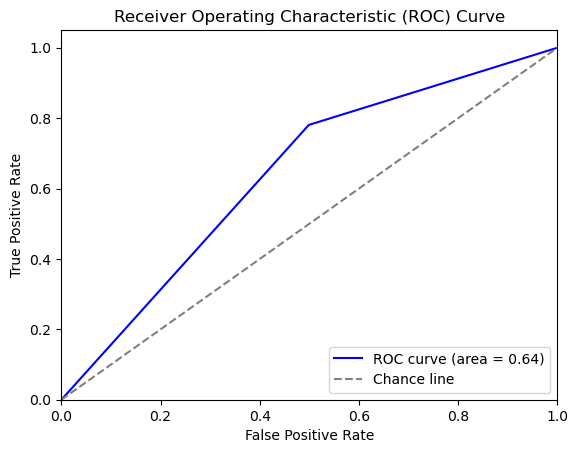

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

y_true = y_test
y_pred_proba = y_pred 
# Compute ROC curve and ROC area
fpr, tpr, thresholds = roc_curve(y_true, y_pred_proba)
roc_auc = auc(fpr, tpr)

# Plotting the ROC curve
plt.figure()
plt.plot(fpr, tpr, color='blue', label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', label='Chance line')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.savefig("results/241118 EU/TabNet_roc_curve.png", dpi=300, bbox_inches='tight')
plt.show()

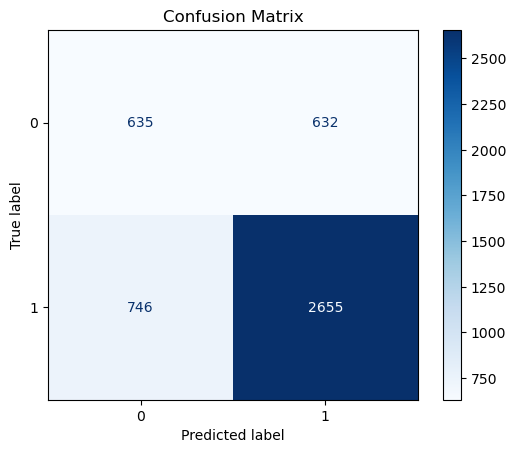

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Compute the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.title("Confusion Matrix")
plt.savefig("results/241118 EU/TabNet_confusion_matrix.png", dpi=300, bbox_inches='tight')
plt.show()